In [25]:
import pandas as pd
from pandas.tseries.offsets import BDay

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as md
from tqdm import trange
import pickle
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from utils.portfolio_backtests import *
from utils.trading_model import *
from utils.experiment_utils import *
from utils.portfolio_backtests import MeanVariance

from cvx.covariance.ewma import iterated_ewma, _ewma_cov, _ewma_mean
from cvx.covariance.combination import from_sigmas

import datetime
import random

sns.set()
sns.set(font_scale=1.5)

boolUniformlyDistributedDataset = False
percentageOfRemovedDays = 20

In [26]:
# code for plotting and compare inside a unique chart prices and volatilities for ewma predictions

def plot_prices_volatilities_for_ewma(stock_prices, real_volatility, real_volatility_startDate, real_volatility_endDate, ewma_volatility, asset_name):
    '''
    Function to plot prices and volatilities for EWMA
    '''
    # filter the real volatility between the start and end date
    real_volatility_startDate = pd.to_datetime(real_volatility_startDate)
    real_volatility_endDate = pd.to_datetime(real_volatility_endDate)

    # Correct way to filter using & operator and parentheses
    real_volatility_filtered = real_volatility[(real_volatility.index >= real_volatility_startDate) & (real_volatility.index <= real_volatility_endDate)]
    
    # filter also the ewma volatility
    ewma_volatility = ewma_volatility[(ewma_volatility.index >= real_volatility_startDate) & (ewma_volatility.index <= real_volatility_endDate)]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 11), sharex=True)

    # Plot stock prices
    ax1.plot(stock_prices[asset_name], label=f'{asset_name} Price', color='green')
    ax1.set_title(f'{asset_name} Stock Prices')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    
    # Plot real and rolling window volatilities
    ax2.plot(real_volatility_filtered, label=f'Real {asset_name} Volatility', color='blue')
    ax2.plot(ewma_volatility, label=f'EWMA {asset_name} Volatility', color='orange', linestyle='--')
    ax2.set_title(f'{asset_name} Volatility: Real vs EWMA')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Volatility')
    ax2.legend(loc='upper left')

    # Set x-axis limits to match the start and end dates
    ax1.set_xlim(left=real_volatility_startDate, right=real_volatility_endDate)
    ax2.set_xlim(left=real_volatility_startDate, right=real_volatility_endDate)

    # Adding vertical lines for specific events
    ax1.axvline(pd.Timestamp('2020-02-24'), color='gray', linestyle='--', lw=2)  # COVID start
    ax1.axvline(pd.Timestamp('2022-02-24'), color='red', linestyle='--', lw=2)  # Ukraine War start

    # Adding vertical lines for specific events
    ax2.axvline(pd.Timestamp('2020-02-24'), color='gray', linestyle='--', lw=2)  # COVID start
    ax2.axvline(pd.Timestamp('2022-02-24'), color='red', linestyle='--', lw=2)  # Ukraine War start
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [27]:
# code to make the dataset not uniformly distributed
def removeRandomDays(returnDataset, D):
    '''
    returnDataset: dataframe of returnDataset
    D: percentage of days to eliminate randomly from the dataset:10 = 10% of the days are eliminated
    '''

    # calculate the size of the dataset(so the lenght of the column)
    datasetSize = len(returnDataset.index)
    number_of_days_to_eliminate = int(datasetSize * D / 100)

    # Define the range of indices that can be removed; avoid the first and last days
    valid_indices = list(range(2, datasetSize - 2)) # Randomly select a group of indices to remove

    #Randomly select a group of indices to remove
    indices_to_remove = sorted(random.sample(valid_indices, number_of_days_to_eliminate))
    print("len of indices to remove and interpolate: " + str(len(indices_to_remove)))
    
    # Create a copy of the DataFrame to perform interpolation
    interpolatedReturns = returnDataset.copy()

    # Interpolate the returns using linear interpolation method
    interpolatedReturns.iloc[indices_to_remove] = np.nan
    interpolatedReturns = interpolatedReturns.interpolate(method='linear', axis=0, limit_area='inside')
    # limit the number of decimals to 6
    interpolatedReturns = interpolatedReturns.round(6)

    # save the interpolated dataset in a csv file
    interpolatedReturns.to_csv("interpolatedReturns.csv")
    
    return interpolatedReturns

# Import Data

In [28]:
stocksPrices = pd.read_csv('data/threeStocksPortfolios.csv', index_col=0, parse_dates=True)
stocksPercentageChangeReturn = pd.read_csv('data/threeStocksPortfolioPercentageChange.csv', index_col=0, parse_dates=True)
uniformlyDistributedReturns = stocksPercentageChangeReturn.copy() # this is a copy of the original dataset returns; i will use this to make it non-uniformly distributed

# Risk-free rate
FF = pd.read_csv('data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

# i have 13 years of trading data; 3273 days; now i will split the dataset into 70% training, 20% validation and 10% test

total_days = len(stocksPrices)
date_70_percent = stocksPrices.index[int(total_days * 0.7)]
date_90_percent = stocksPrices.index[int(total_days * 0.9)]

# 70% training
trainingDataWithPrices = stocksPrices.loc[:date_70_percent]
trainingDataWithPercentageChange = stocksPercentageChangeReturn.loc[:date_70_percent]

# Adjust the start date for the validation set to exclude the last date of the training set
validation_start_date = date_70_percent + BDay(1)

# 20% validation
validationDataWithPrices = stocksPrices.loc[validation_start_date:date_90_percent]
validationDataWithPercentageChange = stocksPercentageChangeReturn.loc[validation_start_date:date_90_percent]

# Adjust the start date for the test set to exclude the last date of the validation set
test_start_date = date_90_percent + BDay(1)

# 10% test
testDataWithPrices = stocksPrices.loc[test_start_date:]
testDataWithPercentageChange = stocksPercentageChangeReturn.loc[test_start_date:]

# print the first date and the last date of each dataset
print("First date of training dataset: ", trainingDataWithPrices.index[0])
print("Last date of training dataset: ", trainingDataWithPrices.index[-1])
print("len of training dataset: ", len(trainingDataWithPrices))

print("\nFirst date of validation dataset: ", validationDataWithPrices.index[0])
print("Last date of validation dataset: ", validationDataWithPrices.index[-1])
print("len of validation dataset: ", len(validationDataWithPrices))

print("\nFirst date of test dataset: ", testDataWithPrices.index[0])
print("Last date of test dataset: ", testDataWithPrices.index[-1])
print("len of test dataset: ", len(testDataWithPrices))

print("\ntotal dataset lenght: ", len(stocksPrices))
print("sum of the three datasets: ", len(trainingDataWithPrices) + len(validationDataWithPrices) + len(testDataWithPrices))

First date of training dataset:  2010-01-04 00:00:00
Last date of training dataset:  2019-02-08 00:00:00
len of training dataset:  2291

First date of validation dataset:  2019-02-11 00:00:00
Last date of validation dataset:  2021-09-14 00:00:00
len of validation dataset:  654

First date of test dataset:  2021-09-15 00:00:00
Last date of test dataset:  2022-12-30 00:00:00
len of test dataset:  327

total dataset lenght:  3272
sum of the three datasets:  3272


In [29]:
print("original returns dataframe dimension: " + str(stocksPercentageChangeReturn.shape))

if not boolUniformlyDistributedDataset:

    # if i consider the non-uniformly distributed dataset, i have to apply the linear interpolation to the data to fill the missing values;
    # so i will have not the original dataset with real values, but a dataset with interpolated values
    stocksPercentageChangeReturn = removeRandomDays(uniformlyDistributedReturns, percentageOfRemovedDays) 
    print("returns dataframe dimention after interpolating random days: " + str(stocksPercentageChangeReturn.shape))

    # now i have to modify also the training, validation and test datasets; not only the complete dataset because otherwise i will have the full dataset with interpolated values
    # and the training, validation and test datasets with real values

    # 70% training
    trainingDataWithPrices = stocksPrices.loc[:date_70_percent]
    trainingDataWithPercentageChange = stocksPercentageChangeReturn.loc[:date_70_percent]

    # Adjust the start date for the validation set to exclude the last date of the training set
    validation_start_date = date_70_percent + BDay(1)

    # 20% validation
    validationDataWithPrices = stocksPrices.loc[validation_start_date:date_90_percent]
    validationDataWithPercentageChange = stocksPercentageChangeReturn.loc[validation_start_date:date_90_percent]

    # Adjust the start date for the test set to exclude the last date of the validation set
    test_start_date = date_90_percent + BDay(1)

    # 10% test
    testDataWithPrices = stocksPrices.loc[test_start_date:]
    testDataWithPercentageChange = stocksPercentageChangeReturn.loc[test_start_date:]


# Import pickle
with open('data/permco_to_ticker.pkl', 'rb') as f:
    permco_to_ticker = pickle.load(f)

# Create a reverse mapping if necessary
ticker_to_permco = {v: k for k, v in permco_to_ticker.items()}

# Replace ticker symbols with PERMCO codes if the ticker symbol is found in the reverse mapping
columns = [ticker_to_permco.get(col, col) for col in stocksPercentageChangeReturn.columns]
stocksPercentageChangeReturn.columns = columns

# Repeat for uniformlyDistributedReturns
columns_udr = [ticker_to_permco.get(col, col) for col in uniformlyDistributedReturns.columns]
uniformlyDistributedReturns.columns = columns_udr

original returns dataframe dimension: (3272, 3)
len of indices to remove and interpolate: 654
returns dataframe dimention after interpolating random days: (3272, 3)


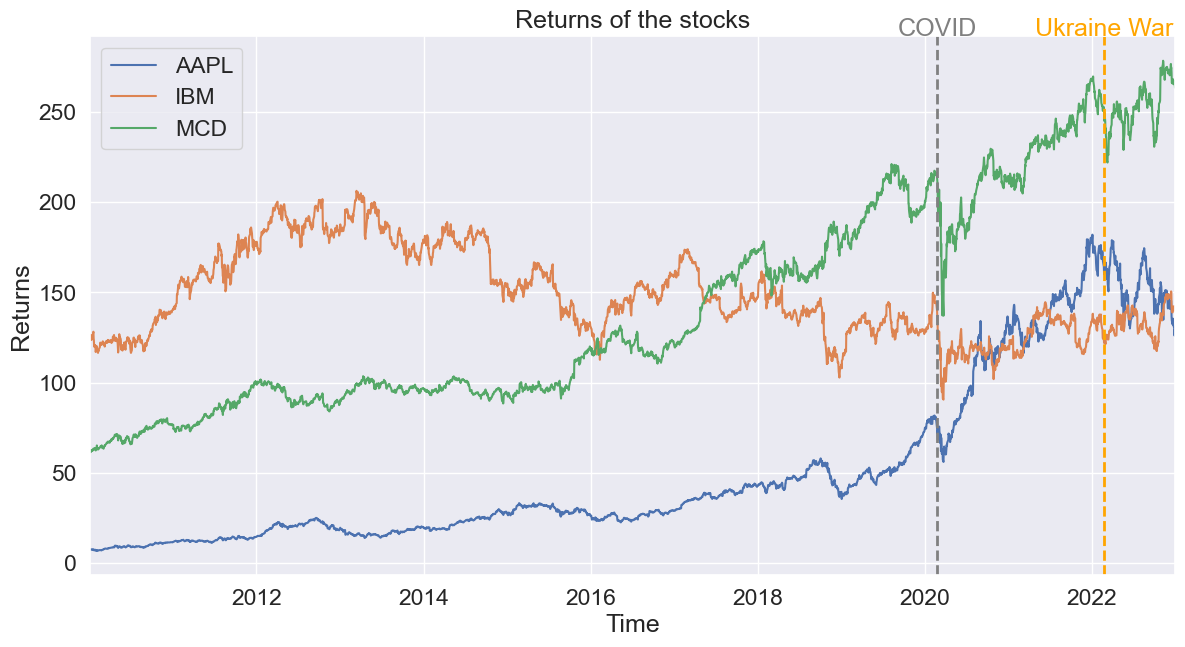

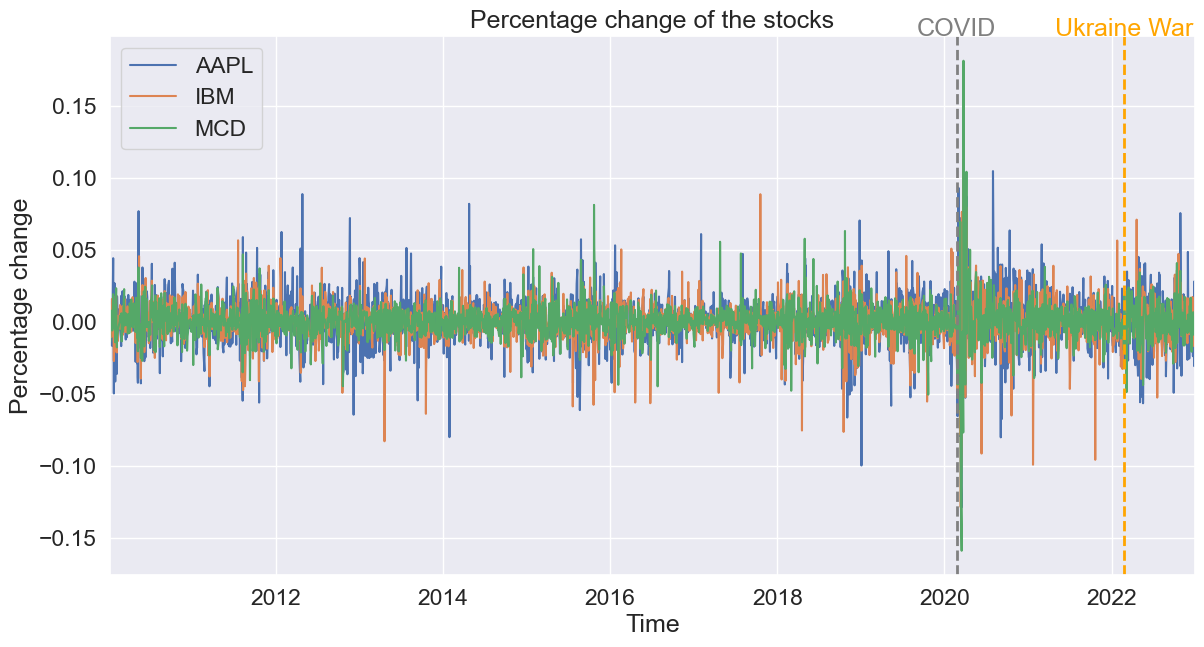

In [30]:
# Plot the returns of the stocks with highlights and annotations
plt.figure(figsize=(14, 7))
plt.plot(stocksPrices)
plt.legend(["AAPL", "IBM", "MCD"])
plt.title("Returns of the stocks")
plt.xlabel("Time")
plt.ylabel("Returns")

# Adding vertical lines for specific events
plt.axvline(pd.Timestamp('2020-02-24'), color='gray', linestyle='--', lw=2)  # COVID start
plt.axvline(pd.Timestamp('2022-02-24'), color='orange', linestyle='--', lw=2)  # Ukraine War start

# Annotations for the events
plt.text(pd.Timestamp('2020-02-24'), plt.ylim()[1], 'COVID', horizontalalignment='center', color='gray')
plt.text(pd.Timestamp('2022-02-24'), plt.ylim()[1], 'Ukraine War', horizontalalignment='center', color='orange')

plt.xlim(left=stocksPrices.index[0], right=stocksPrices.index[-1])
plt.show()


# Plot also the percentage change of the stocks with highlights and annotations
plt.figure(figsize=(14, 7))
plt.plot(stocksPercentageChangeReturn)
plt.legend(["AAPL", "IBM", "MCD"])
plt.title("Percentage change of the stocks")
plt.xlabel("Time")
plt.ylabel("Percentage change")

# Adding vertical lines for specific events
plt.axvline(pd.Timestamp('2020-02-24'), color='gray', linestyle='--', lw=2)  # COVID start
plt.axvline(pd.Timestamp('2022-02-24'), color='orange', linestyle='--', lw=2)  # Ukraine War start

# Annotations for the events
plt.text(pd.Timestamp('2020-02-24'), plt.ylim()[1], 'COVID', horizontalalignment='center', color='gray')
plt.text(pd.Timestamp('2022-02-24'), plt.ylim()[1], 'Ukraine War', horizontalalignment='center', color='orange')

plt.xlim(left=stocksPercentageChangeReturn.index[0], right=stocksPercentageChangeReturn.index[-1])
plt.show()

# Dictionary Initialization

In [31]:
prescientDict = {}
log_likelihoods = {}
regrets = {}

# create a dictionary for every predictor that saves the log-likelihoods and the regrets
log_likelihood_ewma = {}
log_likelihood_prescient = {}

regret_ewma = {}
regret_prescient = {}

# collections for plotting charts about the performance of the EWMA predictor
betaValues = []
ewmaMeanRegretValues = []
ewmaMeanlogLikelihoodValues = []
prescientAlreadyPrinted = False

days_greater_than_one_values = []  # To store determinant values where > 1
days_less_than_one_values = []  # To store determinant values where < 1

# Covariance Predictors

PRESCIENT(GROUND TRUTH)

In [32]:
# THIS CODE IS CALCULATING THE REAL VOLATILITY

# prescient is a dictionary that contains the covariance matrix calculated using the ewma formula written inside the paper
# the key of the dictionary is the timestamp and the value is the covariance matrix calculated for that day

# The prescient predictor will always use the original dataset, so it will be uniformly distributed; this is because the prescient predictor is used to compare the other predictors
# and we need to have a measure of the real covariance matrix; so this can't be used with the non-uniformly distributed dataset

for t in uniformlyDistributedReturns.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    cov = np.cov(uniformlyDistributedReturns.loc[(uniformlyDistributedReturns.index.year == t.year) & (uniformlyDistributedReturns.index.quarter == quarter)].values, rowvar=False)
    mean = np.mean(uniformlyDistributedReturns.loc[(uniformlyDistributedReturns.index.year == t.year) & (uniformlyDistributedReturns.index.quarter == quarter)].values, axis=0)
    prescientDict[t] = pd.DataFrame(cov+np.outer(mean, mean), index=uniformlyDistributedReturns.columns, columns=uniformlyDistributedReturns.columns)

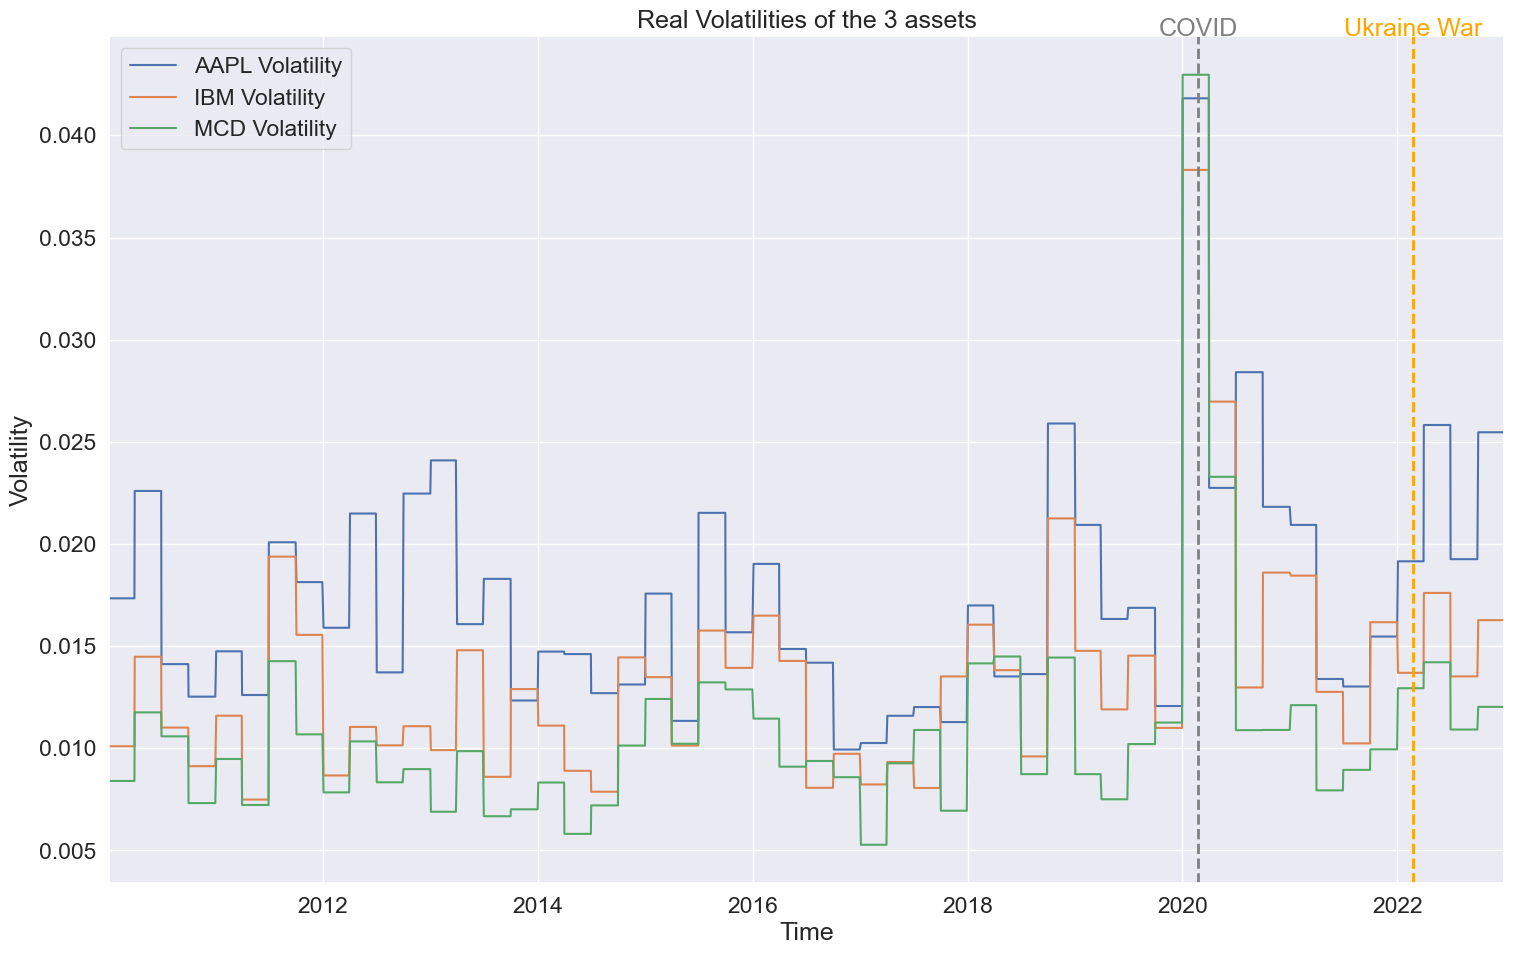

In [33]:
# THIS IS THE VISUALIZATION OF THE REAL VOLAITILITIES OF THE 3 ASSETS

# now calculates/extract the real volatilities of the 3 assets
real_volatilities = {}

for date, cov_matrix in prescientDict.items():
    volatilities = np.sqrt(np.diag(cov_matrix.values))
    real_volatilities[date] = pd.DataFrame(data = volatilities, index = cov_matrix.index, columns = ["volatility"])

# now real_volatilities is a dictionary that contains the real volatilities of the 3 assets for every day with the same key of the prescientDict dictionary(the timestamp)

# now separate the real volatilities of the 3 assets in 3 different dataframes
volatility_dict_aapl = {}
volatility_dict_ibm = {}
volatility_dict_mcd = {}

for date, volatilities in real_volatilities.items():
    volatility_dict_aapl[date] = volatilities.loc[7]["volatility"] # 7 is the PERMCO code of AAPL
    volatility_dict_ibm[date] = volatilities.loc[20990]["volatility"] # 20990 is the PERMCO code of IBM
    volatility_dict_mcd[date] = volatilities.loc[21177]["volatility"] # 21177 is the PERMCO code of MCD

# Convert the dictionaries to DataFrames for easier manipulation and plotting
df_volatility_aapl = pd.DataFrame(list(volatility_dict_aapl.items()), columns=['Date', 'AAPL Volatility'])
df_volatility_ibm = pd.DataFrame(list(volatility_dict_ibm.items()), columns=['Date', 'IBM Volatility'])
df_volatility_mcd = pd.DataFrame(list(volatility_dict_mcd.items()), columns=['Date', 'MCD Volatility'])

# Set the 'Date' column as the index
df_volatility_aapl.set_index('Date', inplace=True)
df_volatility_ibm.set_index('Date', inplace=True)
df_volatility_mcd.set_index('Date', inplace=True)

# Plot the real volatilities of the 3 assets
plt.figure(figsize=(18, 11))
plt.plot(df_volatility_aapl, label='AAPL Volatility')
plt.plot(df_volatility_ibm, label='IBM Volatility')
plt.plot(df_volatility_mcd, label='MCD Volatility')
plt.legend()
plt.title("Real Volatilities of the 3 assets")
plt.xlabel("Time")
plt.ylabel("Volatility")

# Adding vertical lines for specific events
plt.axvline(pd.Timestamp('2020-02-24'), color='gray', linestyle='--', lw=2)  # COVID start
plt.axvline(pd.Timestamp('2022-02-24'), color='orange', linestyle='--', lw=2)  # Ukraine War start

# Annotations for the events
plt.text(pd.Timestamp('2020-02-24'), plt.ylim()[1], 'COVID', horizontalalignment='center', color='gray')
plt.text(pd.Timestamp('2022-02-24'), plt.ylim()[1], 'Ukraine War', horizontalalignment='center', color='orange')

# Set x-axis limits to match the start and end dates
plt.xlim(left=df_volatility_aapl.index[0], right=df_volatility_aapl.index[-1])

plt.show()

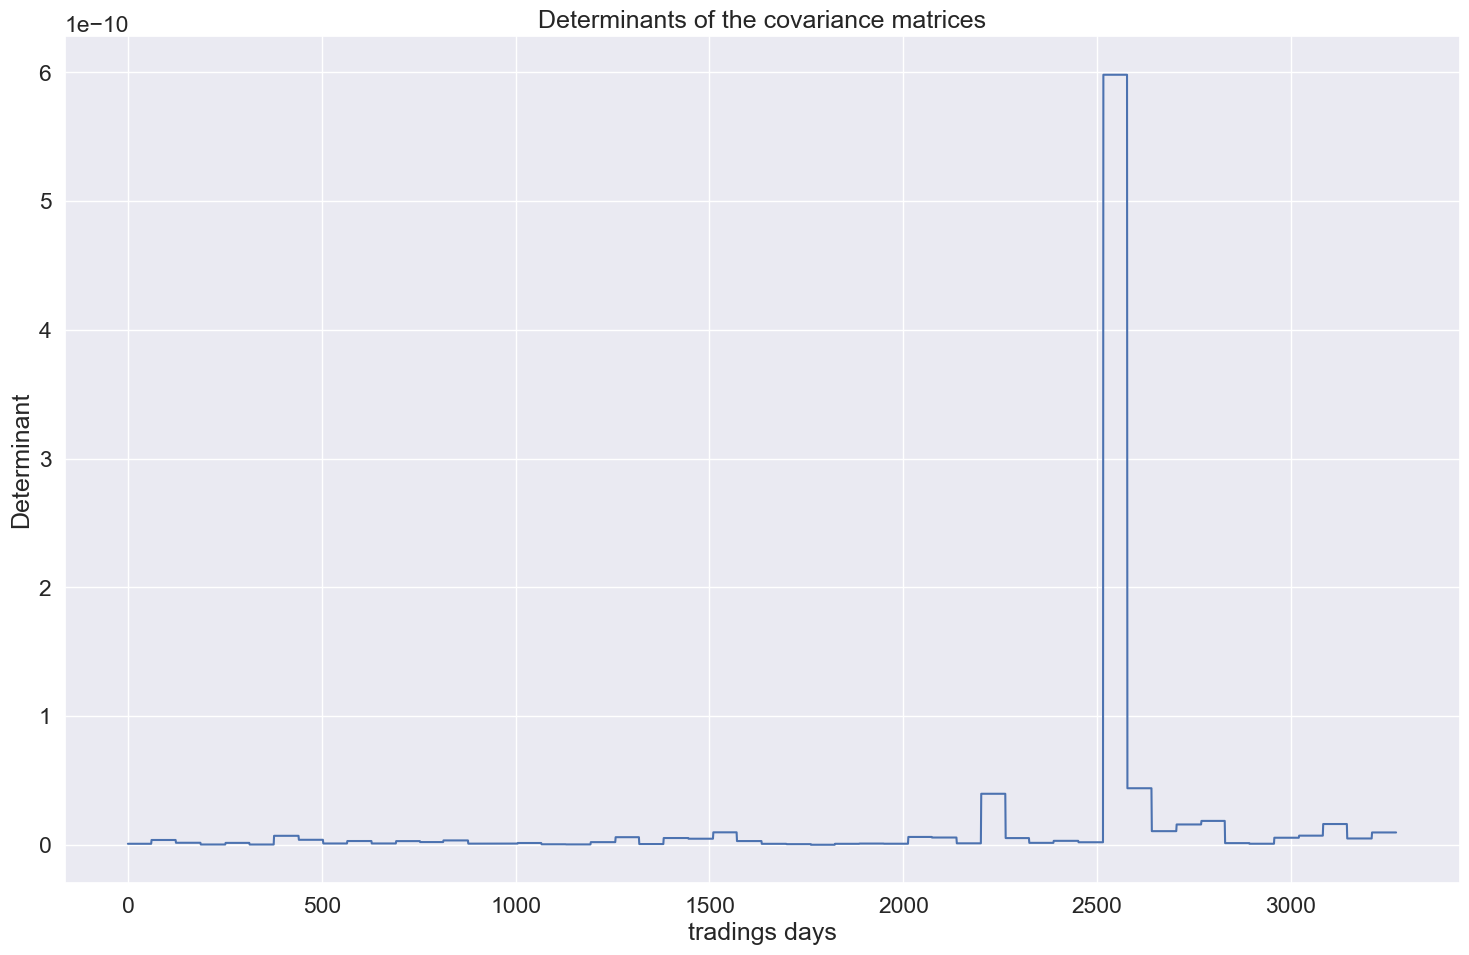

In [34]:
# HERE THERE IS A BRIEF STUDY OF THE DETERMINANTS OF THE COVARIANCE MATRICES; SO THIS EXPLAINS WHY THE LOG LIKELIHOOD OF THE PRESCIENT PREDICTOR IS POSITIVE
# this because from the chart is clear that for every trading day the determinant of the covariance matrix is lower than 1; so the log term became positive

# now let's study why the prescient predictor has a positive log-likelihood and a 0 regret: i make a list off all the determinants of the covariance matrices and i plot them
determinants = []
for date, cov_matrix in prescientDict.items():
    determinants.append(np.linalg.det(cov_matrix))

# in particular i want to se if it is greater than 1 or not
plt.figure(figsize=(18, 11))
plt.plot(determinants)
plt.title("Determinants of the covariance matrices")
plt.xlabel("tradings days")
plt.ylabel("Determinant")
plt.show()

FOR THE EWMA PREDICTOR THERE IS NO TRAINING PHASE, THE PREDICTOR HAS BETA AS UNIQUE PARAMETER AND IT IS AN HYPERPARAMETER (0 < BETA < 1). 
The best value for beta has been found with the grid search method applied in the validation phase.

# Validation Phase for EWMA predictor

In [35]:
# Loop through beta values
# ewma_halflife = 100
# beta = 2 ** (-1 / ewma_halflife)
# beta = 0.1

def ewmaValidationPhase(betaValue, startingDate, endingDate, betaIncrement, prescientAlreadyPrinted):
    '''
    this function is used to perform the validation phase of the EWMA predictor; it's used to find the best beta value for the EWMA predictor.
    Grid search is used and the performance of the beta hyperparameter is evaluated using the MSE, log-likelihood and regret metrics.
    '''

    while betaValue < 1:

        ewma_halflife = -np.log(2) / np.log(betaValue)
        ewmaDict = dict(_ewma_cov(stocksPercentageChangeReturn, halflife=ewma_halflife))

        #
        # DEFINE END AND START DATES FOR BACKTESTS
        #
        
        start_date = pd.to_datetime(startingDate, format="%Y-%m-%d")
        end_date = pd.to_datetime(endingDate, format="%Y-%m-%d")

        names = ["EWMA", "PRESCIENT"]

        #these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
        predictors_temp = [ewmaDict, prescientDict]
        predictors = [] # so this is a list of dictionaries

        for predictor in predictors_temp:
            predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})


        #
        # MSEs
        #
            
        for i, predictorDict in enumerate(predictors):
            if names[i] != "PRESCIENT":
                MSE_temp = MSE(stocksPercentageChangeReturn, predictorDict).resample("Q").mean()

        #
        # LOG-LIKELIHOODS
        #

        '''
            this dictionary has a shape like this:
            {
                RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
            }

            where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
        '''

        for i, predictorDict in enumerate(predictors):

            # if the predictor is the prescient predictor, i have to use the uniformly distributed dataset
            if names[i] == "PRESCIENT":
                returns_temp = uniformlyDistributedReturns.loc[pd.Series(predictorDict).index].values[1:]
            
            else:
                returns_temp = stocksPercentageChangeReturn.loc[pd.Series(predictorDict).index].values[1:]

            times = pd.Series(predictorDict).index[1:]
            Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
            log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)


        #
        # REGRETS
        #

        for name in log_likelihoods:
            regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]
            
        for name in regrets:
            if name != "PRESCIENT":

                #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
                regret = regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
                # so the regret variable is a series of average regret for each quarter
                
                regretMetrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
                # the round(1) function to each of these metrics, which rounds the result to one decimal place,

                # save the regret mean values to plot a chart
                ewmaMeanRegretValues.append(regretMetrics[0])


        # copy the log-likelihoods dictionary
        log_likelihoods_copy = log_likelihoods.copy()

        # do the same thing for log-likelihoods dictionary
        for name in log_likelihoods_copy:
            logLikelihood = log_likelihoods_copy[name].resample("Q").mean()
            logLikelihoodMetrics = (np.mean(logLikelihood).round(1), np.std(logLikelihood).round(1), np.max(logLikelihood).round(1))

            if name != "PRESCIENT":

                # save the loglikelihood mean values to plot a chart
                ewmaMeanlogLikelihoodValues.append(logLikelihoodMetrics[0])
                
            if name == "PRESCIENT" and prescientAlreadyPrinted == False:
                prescientAlreadyPrinted = True

                # save the loglikelihood mean value to plot a chart
                prescientMeanlogLikelihoodValue = logLikelihoodMetrics[0]

        # save every fundamental value to plot a chart 
        betaValues.append(betaValue)

        # Increment beta
        betaValue += betaIncrement

    # return the fundamental values to plot a chart
    return betaValues, ewmaMeanRegretValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue

In [36]:
# this function is used to plot the performance of the ewma predictor in terms of regret and log-likelihood

def plotLogLikelihoodPerformanceEWMA(betaValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue):
    '''
    plotting the results of the grid search expressed in terms of regret
    '''

    betaMaxValuesLogLikelihood = [] # this list will contain the beta values that have the max loglikelihood value

    # plot the chart of the mean loglikelihood values
    plt.figure()
    plt.plot(betaValues, ewmaMeanlogLikelihoodValues)
    plt.xlabel("Beta values")
    plt.ylabel("Mean loglikelihood values")
    plt.title("Mean loglikelihood values for different beta values")

    # show the prescient predictor loglikelihood value
    plt.axhline(y=prescientMeanlogLikelihoodValue, color='r', linestyle='-')
    plt.legend(["EWMA", "PRESCIENT"])

    for j in range(len(ewmaMeanlogLikelihoodValues)):
        if ewmaMeanlogLikelihoodValues[j] == max(ewmaMeanlogLikelihoodValues):
            betaMaxValuesLogLikelihood.append(betaValues[j])

    # these points show the interval of beta values that have the max loglikelihood value
    highlightPoint1LogLikelihood = betaMaxValuesLogLikelihood[0]
    plt.scatter(highlightPoint1LogLikelihood, max(ewmaMeanlogLikelihoodValues), color='r')
    #plt.text(highlightPoint1LogLikelihood, max(ewmaMeanlogLikelihoodValues), f' Beta: {highlightPoint1LogLikelihood:.4f}\n Loglikelihood: {max(ewmaMeanlogLikelihoodValues):.4f}',
            #fontsize=9, color='red', ha='center', va='bottom')

    highlightPoint2LogLikelihood = betaMaxValuesLogLikelihood[-1]
    plt.scatter(highlightPoint2LogLikelihood, max(ewmaMeanlogLikelihoodValues), color='r')
    #plt.text(highlightPoint2LogLikelihood, max(ewmaMeanlogLikelihoodValues), f' Beta: {highlightPoint2LogLikelihood:.4f}\n Loglikelihood: {max(ewmaMeanlogLikelihoodValues):.4f}',
            #fontsize=9, color='red', ha='center', va='bottom')

    # find the y value coordinate corresponding to the highlightPoint1LogLikelihood and highlightPoint2LogLikelihood
    highlightPoint1LogLikelihoodIndex = betaValues.index(highlightPoint1LogLikelihood)
    highlightPoint1LogLikelihoodY = ewmaMeanlogLikelihoodValues[highlightPoint1LogLikelihoodIndex]

    highlightPoint2LogLikelihoodIndex = betaValues.index(highlightPoint2LogLikelihood)
    highlightPoint2LogLikelihoodY = ewmaMeanlogLikelihoodValues[highlightPoint2LogLikelihoodIndex]

    print("highlightPoint1LogLikelihoodX: " + str(highlightPoint1LogLikelihood))
    print("highlightPoint1LogLikelihoodY: " + str(highlightPoint1LogLikelihoodY))

    print("highlightPoint2LogLikelihoodX: " + str(highlightPoint2LogLikelihood))
    print("highlightPoint2LogLikelihoodY: " + str(highlightPoint2LogLikelihoodY))

    # set the x-axis limits 
    plt.xlim(left = betaValues[0], right = betaValues[-1])
    
    plt.show()


def plotRegretperformanceEWMA(betaValues, ewmaMeanRegretValues):
    '''
    plotting the results of the grid search expressed in terms of regret
    '''

    betaMinValuesRegret = [] # this list will contain the beta values that have the minimum regret value

    # plot the chart of the mean regret values
    plt.figure()
    plt.plot(betaValues, ewmaMeanRegretValues)
    plt.xlabel("Beta values")
    plt.ylabel("Mean regret values")
    plt.title("Mean regret values for different beta values")

    # find the minimum value of the mean regret values
    for i in range(len(ewmaMeanRegretValues)):
        if ewmaMeanRegretValues[i] == min(ewmaMeanRegretValues):
            betaMinValuesRegret.append(betaValues[i])

    # these points show the interval of beta values that have the minimum regret value
    highlightPoint1 = betaMinValuesRegret[0]
    plt.scatter(highlightPoint1, min(ewmaMeanRegretValues), color='r')
    #plt.text(highlightPoint1, min(ewmaMeanRegretValues), f' Beta: {highlightPoint1:.4f}\n Regret: {min(ewmaMeanRegretValues):.4f}',
            #fontsize=9, color='red', ha='center', va='bottom')

    highlightPoint2 = betaMinValuesRegret[-1]
    plt.scatter(highlightPoint2, min(ewmaMeanRegretValues), color='r')
    #plt.text(highlightPoint2, min(ewmaMeanRegretValues), f' Beta: {highlightPoint2:.4f}\n Regret: {min(ewmaMeanRegretValues):.4f}',
            #fontsize=9, color='red', ha='center', va='bottom')

    # find the y value coordinate corresponding to the highlightPoint1 and highlightPoint2
    highlightPoint1Index = betaValues.index(highlightPoint1)
    highlightPoint1Y = ewmaMeanRegretValues[highlightPoint1Index]

    highlightPoint2Index = betaValues.index(highlightPoint2)
    highlightPoint2Y = ewmaMeanRegretValues[highlightPoint2Index]
    
    print("highlightPoint1X: " + str(highlightPoint1))
    print("highlightPoint1Y: " + str(highlightPoint1Y))
    
    print("highlightPoint2X: " + str(highlightPoint2))
    print("highlightPoint2Y: " + str(highlightPoint2Y))

    # set the x-axis limits 
    plt.xlim(left = betaValues[0], right = betaValues[-1])

    plt.show()

In [37]:
def plotPerformanceEWMA(betaValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue, ewmaMeanRegretValues):
    '''
    plotting the results of the grid search expressed in terms of loglikelihood and regret on a single chart
    '''
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the mean log-likelihood values for EWMA
    color = 'tab:blue'
    ax1.set_xlabel('Beta values')
    ax1.set_ylabel('Mean log-likelihood', color=color)
    ax1.plot(betaValues, ewmaMeanlogLikelihoodValues, color=color, label='Loglikelihood EWMA')
    ax1.tick_params(axis='y', labelcolor=color)

    # Plot the loglikelihood value of the prescient predictor
    ax1.axhline(y=prescientMeanlogLikelihoodValue, color='tab:green', linestyle='-', label='Loglikelihood PRESCIENT')

    # Highlight the maximum log-likelihood points
    max_log_likelihood = max(ewmaMeanlogLikelihoodValues)
    max_points = [beta for beta, value in zip(betaValues, ewmaMeanlogLikelihoodValues) if value == max_log_likelihood]

    # take just the first and last element of the list
    max_points = [max_points[0], max_points[-1]]

    # scatter the points by writing the beta value and the loglikelihood value on the chart
    for point in max_points:
        ax1.scatter(point, max_log_likelihood, color='green')
        plt.text(point, max_log_likelihood, f' x: {point:.3f}\n y: {max_log_likelihood:.3f}', fontsize=9, color='green', ha='center', va='bottom')

    # Add a second y-axis for the regret values
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Mean regret', color=color)  
    ax2.plot(betaValues, ewmaMeanRegretValues, color=color, label='Regret EWMA')
    ax2.tick_params(axis='y', labelcolor=color)

    # Highlight the minimum regret points
    min_regret = min(ewmaMeanRegretValues)
    min_points = [beta for beta, value in zip(betaValues, ewmaMeanRegretValues) if value == min_regret]

    # take just the first and last element of the list
    min_points = [min_points[0], min_points[-1]]

    # scatter the points by writing the beta value and the regret value on the chart
    for point in min_points:
        ax2.scatter(point, min_regret, color='red')
        plt.text(point, min_regret, f' x: {point:.3f}\n y: {min_regret:.3f}', fontsize=9, color='red', ha='center', va='bottom')

    print("max_points: " + str(max_points))
    print("min_points: " + str(min_points))

    # Create the legend, which combines both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='center')

    # Add title
    plt.title("Performance of EWMA for different beta values")

    # Set the x-axis limits
    ax1.set_xlim(left=betaValues[0], right=betaValues[-1])

    fig.tight_layout()  # to ensure the right y-label is not slightly clipped
    plt.show()


In [38]:
# first of all define the starting and ending date for the validation phase: take the first and the last date of the validation dataset
startingValidationDate = validationDataWithPercentageChange.index[0].strftime("%Y-%m-%d")
endingValidationDate = validationDataWithPercentageChange.index[-1].strftime("%Y-%m-%d")

highlightPoint1LogLikelihoodX: 0.9000000000000007
highlightPoint1LogLikelihoodY: 8.5
highlightPoint2LogLikelihoodX: 0.9700000000000008
highlightPoint2LogLikelihoodY: 8.5


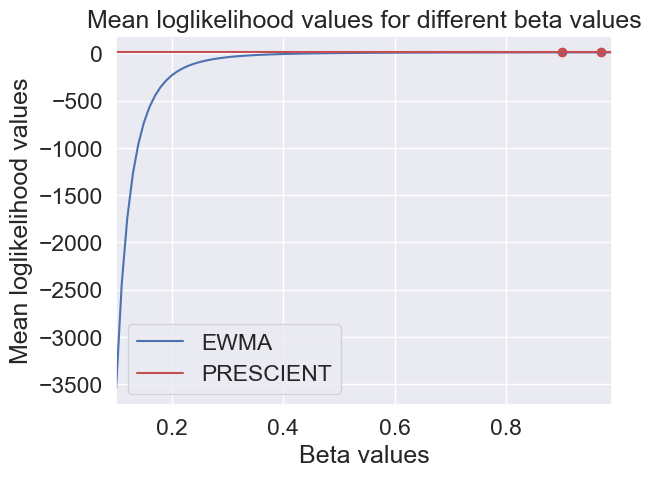

highlightPoint1X: 0.9000000000000007
highlightPoint1Y: 0.1
highlightPoint2X: 0.9700000000000008
highlightPoint2Y: 0.1


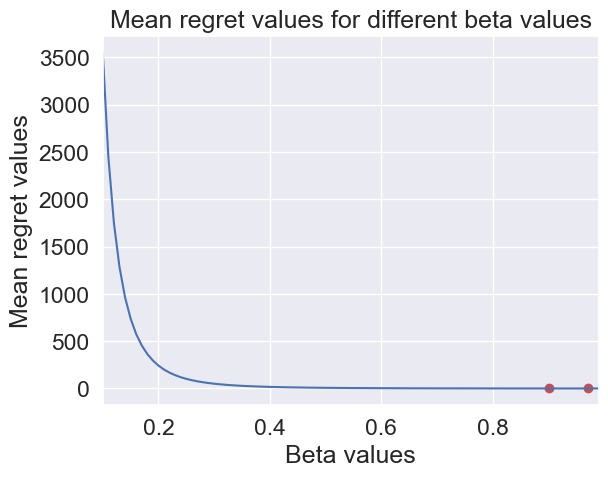

max_points: [0.9000000000000007, 0.9700000000000008]
min_points: [0.9000000000000007, 0.9700000000000008]


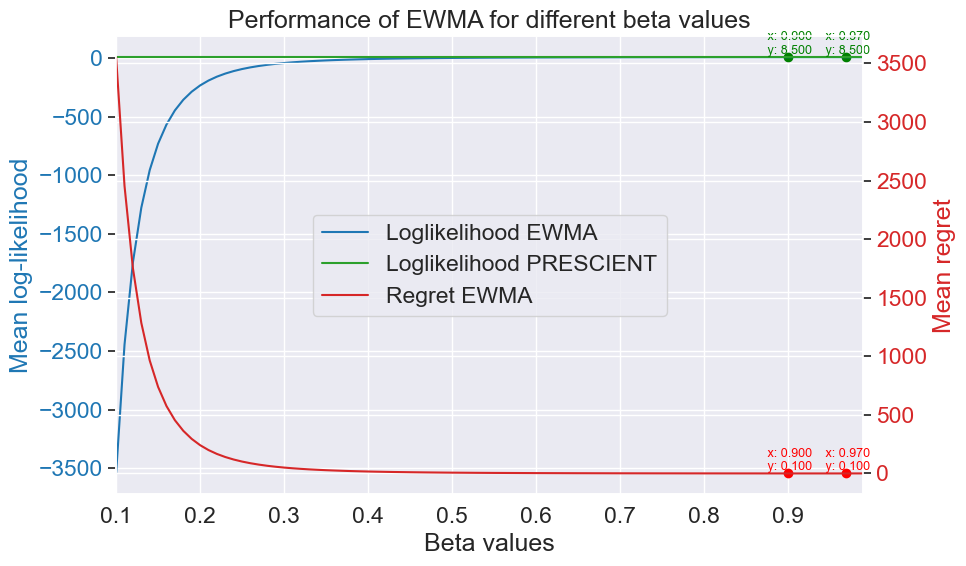

In [39]:
# first run for grid search -> this is a general run to cover the entire range of beta values
betaValues, ewmaMeanRegretValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue = ewmaValidationPhase(0.1, startingValidationDate, endingValidationDate, 0.01, prescientAlreadyPrinted)

# plot the performance of the EWMA predictor in terms of loglikelihood
plotLogLikelihoodPerformanceEWMA(betaValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue)

# plot the performance of the EWMA predictor in terms of regret
plotRegretperformanceEWMA(betaValues, ewmaMeanRegretValues)

plotPerformanceEWMA(betaValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue, ewmaMeanRegretValues)

From the chart is evident that the model has the best performance with 0.9 < beta < 1; so now i will do the zoom in this range

highlightPoint1LogLikelihoodX: 0.9
highlightPoint1LogLikelihoodY: 8.5
highlightPoint2LogLikelihoodX: 0.9790000000000001
highlightPoint2LogLikelihoodY: 8.5


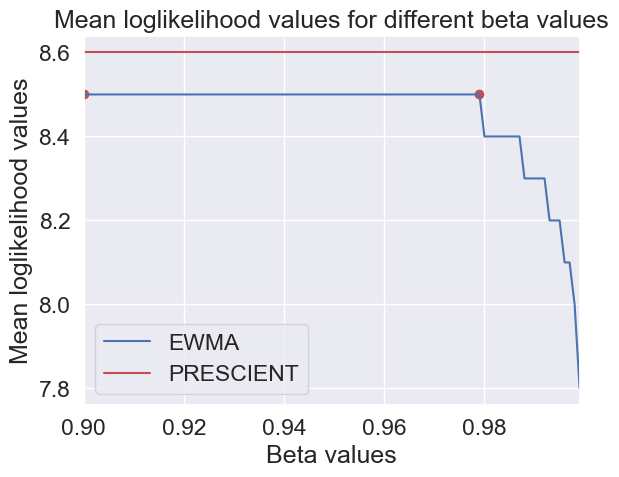

highlightPoint1X: 0.9
highlightPoint1Y: 0.1
highlightPoint2X: 0.9780000000000001
highlightPoint2Y: 0.1


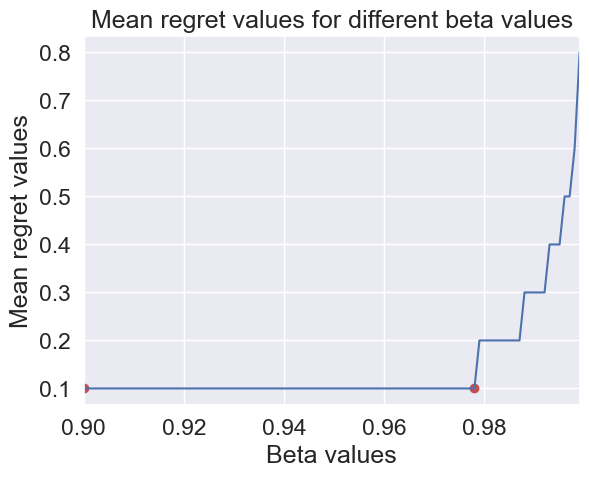

max_points: [0.9, 0.9790000000000001]
min_points: [0.9, 0.9780000000000001]


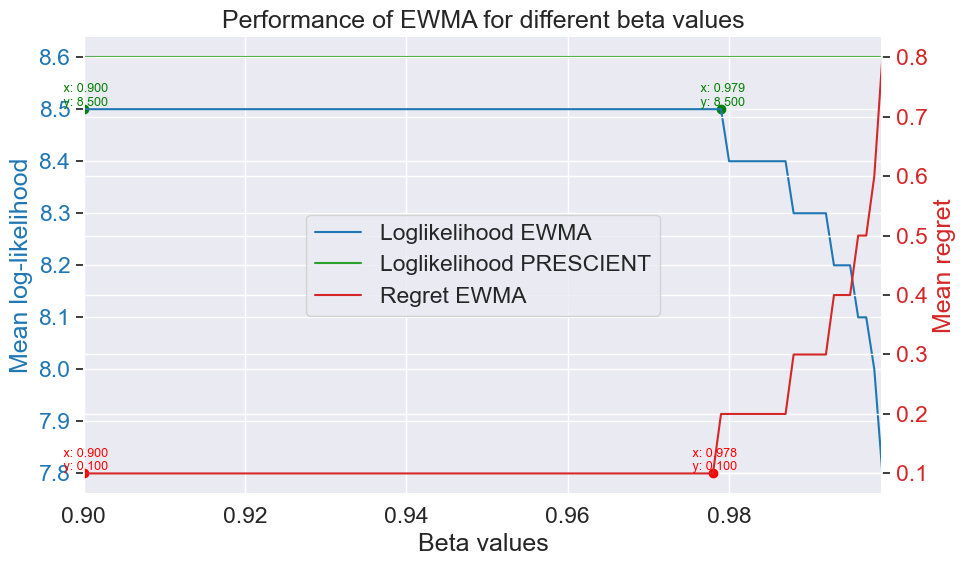

In [40]:
# clear the lists to make another run of the grid search
betaValues.clear()
ewmaMeanRegretValues.clear()
ewmaMeanlogLikelihoodValues.clear()
prescientMeanlogLikelihoodValue = 0

# this is a specific run to find the best beta value (i will search in the range 0.9 -> 1 with a step of 0.001)
betaValues, ewmaMeanRegretValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue = ewmaValidationPhase(0.9, startingValidationDate, endingValidationDate, 0.001, prescientAlreadyPrinted)

# plot the performance of the EWMA predictor in terms of loglikelihood
plotLogLikelihoodPerformanceEWMA(betaValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue)

# plot the performance of the EWMA predictor in terms of regret
plotRegretperformanceEWMA(betaValues, ewmaMeanRegretValues)

plotPerformanceEWMA(betaValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue, ewmaMeanRegretValues)

In [41]:
# print the log likelihood value and regret value for beta = 0.97
Beta = 0.9700000000000001
ewma_halflife = -np.log(2) / np.log(Beta)

print("betavalues: " + str(betaValues))

print("beta: " + str(Beta))
print("ewma_halflife: " + str(ewma_halflife))
print("log likelihood: " + str(ewmaMeanlogLikelihoodValues[betaValues.index(Beta)]))
print("regret: " + str(ewmaMeanRegretValues[betaValues.index(Beta)]))

betavalues: [0.9, 0.901, 0.902, 0.903, 0.904, 0.905, 0.906, 0.907, 0.908, 0.909, 0.91, 0.911, 0.912, 0.913, 0.914, 0.915, 0.916, 0.917, 0.918, 0.919, 0.92, 0.921, 0.922, 0.923, 0.924, 0.925, 0.926, 0.927, 0.928, 0.929, 0.93, 0.931, 0.932, 0.933, 0.934, 0.935, 0.936, 0.937, 0.9380000000000001, 0.9390000000000001, 0.9400000000000001, 0.9410000000000001, 0.9420000000000001, 0.9430000000000001, 0.9440000000000001, 0.9450000000000001, 0.9460000000000001, 0.9470000000000001, 0.9480000000000001, 0.9490000000000001, 0.9500000000000001, 0.9510000000000001, 0.9520000000000001, 0.9530000000000001, 0.9540000000000001, 0.9550000000000001, 0.9560000000000001, 0.9570000000000001, 0.9580000000000001, 0.9590000000000001, 0.9600000000000001, 0.9610000000000001, 0.9620000000000001, 0.9630000000000001, 0.9640000000000001, 0.9650000000000001, 0.9660000000000001, 0.9670000000000001, 0.9680000000000001, 0.9690000000000001, 0.9700000000000001, 0.9710000000000001, 0.9720000000000001, 0.9730000000000001, 0.9740

ewma_halflife used: 692.8005491785002



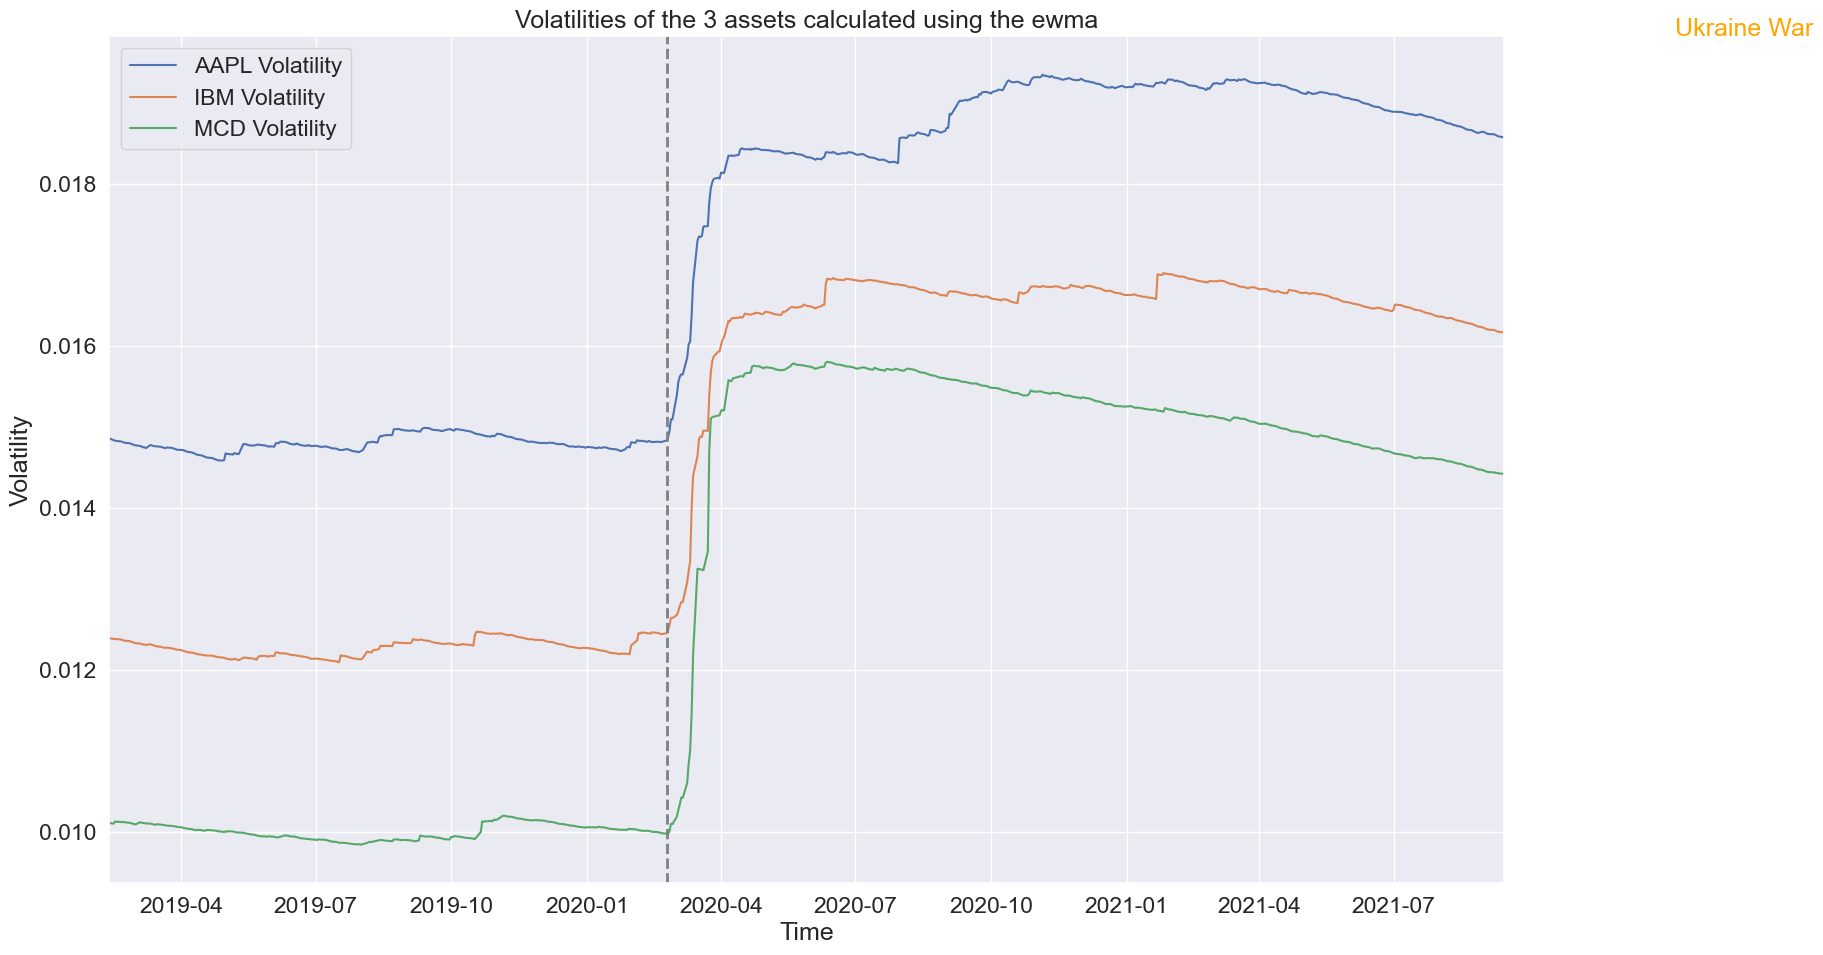

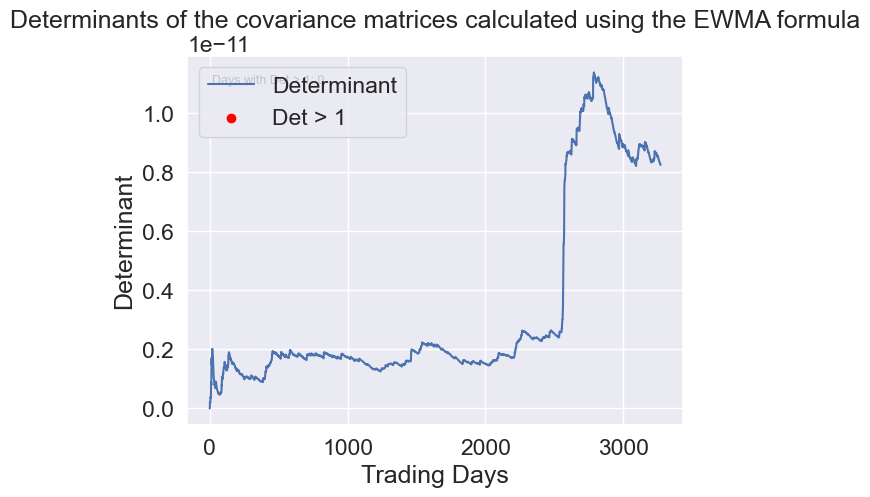

In [42]:
# prepare the date for the test phase
prescientAlreadyPrinted = False
startingTestDate = validationDataWithPercentageChange.index[0].strftime("%Y-%m-%d")
endingTestDate = validationDataWithPercentageChange.index[-1].strftime("%Y-%m-%d")

# select the best beta value for the EWMA predictor (the one found in the previous step)
beta = 0.999

ewma_halflife = -np.log(2) / np.log(beta)

# now i will use the best beta value to perform the test phase

# now i want to print the repective value of beta: the beta is the value of the decay factor used in the ewma formula
print("ewma_halflife used: " + str(ewma_halflife) + "\n")

# ewma is a dictionary that contains the covariance matrix calculated using the ewma formula written inside the paper
# the key of the dictionary is the timestamp and the value is the covariance matrix calculated for that day
ewmaDict = dict(_ewma_cov(stocksPercentageChangeReturn, ewma_halflife))

ewma_volatilities = {}

for date, cov_matrix in ewmaDict.items():
    volatilities = np.sqrt(np.diag(cov_matrix.values))
    ewma_volatilities[date] = pd.DataFrame(data = volatilities, index = cov_matrix.index, columns = ["volatility"])

# now ewma_volatilities is a dictionary that contains the real volatilities of the 3 assets for every day with the same key of the ewmaDict dictionary(the timestamp)

# now filter the ewma volatilities between the start and end date
real_volatility_startDate = pd.to_datetime(startingTestDate)
real_volatility_endDate = pd.to_datetime(endingTestDate)

# filter the dictionary
ewma_volatilities = {k: v for k, v in ewma_volatilities.items() if k >= real_volatility_startDate and k <= real_volatility_endDate}
    
# now separate the real volatilities of the 3 assets in 3 different dataframes
ewma_volatility_dict_aapl = {}
ewma_volatility_dict_ibm = {}
ewma_volatility_dict_mcd = {}

for date, volatilities in ewma_volatilities.items():
    ewma_volatility_dict_aapl[date] = volatilities.loc[7]["volatility"] # 7 is the PERMCO code of AAPL
    ewma_volatility_dict_ibm[date] = volatilities.loc[20990]["volatility"] # 20990 is the PERMCO code of IBM
    ewma_volatility_dict_mcd[date] = volatilities.loc[21177]["volatility"] # 21177 is the PERMCO code of MCD

# Convert the dictionaries to DataFrames for easier manipulation and plotting
df_ewma_volatility_aapl = pd.DataFrame(list(ewma_volatility_dict_aapl.items()), columns=['Date', 'AAPL Volatility'])
df_ewma_volatility_ibm = pd.DataFrame(list(ewma_volatility_dict_ibm.items()), columns=['Date', 'IBM Volatility'])
df_ewma_volatility_mcd = pd.DataFrame(list(ewma_volatility_dict_mcd.items()), columns=['Date', 'MCD Volatility'])

# Set the 'Date' column as the index
df_ewma_volatility_aapl.set_index('Date', inplace=True)
df_ewma_volatility_ibm.set_index('Date', inplace=True)
df_ewma_volatility_mcd.set_index('Date', inplace=True)

# Plot the real volatilities of the 3 assets
plt.figure(figsize=(18, 11))
plt.plot(df_ewma_volatility_aapl, label='AAPL Volatility')
plt.plot(df_ewma_volatility_ibm, label='IBM Volatility')
plt.plot(df_ewma_volatility_mcd, label='MCD Volatility')
plt.legend()
plt.title("Volatilities of the 3 assets calculated using the ewma")
plt.xlabel("Time")
plt.ylabel("Volatility")

# Adding vertical lines for specific events
plt.axvline(pd.Timestamp('2020-02-24'), color='gray', linestyle='--', lw=2)  # COVID start
plt.axvline(pd.Timestamp('2022-02-24'), color='orange', linestyle='--', lw=2)  # Ukraine War start

# Annotations for the events
#plt.text(pd.Timestamp('2020-02-24'), plt.ylim()[1], 'COVID', horizontalalignment='center', color='gray')
plt.text(pd.Timestamp('2022-02-24'), plt.ylim()[1], 'Ukraine War', horizontalalignment='center', color='orange')

# set x-axis limits to match the start and end dates
plt.xlim(left=df_ewma_volatility_aapl.index[0], right=df_ewma_volatility_aapl.index[-1])
plt.show()

# here i study the determinants of the covariance matrices calculated using the ewma formula
determinants_ewma = []
indices = []  # To store the indices for the x-axis
days_greater_than_one_indices = []  # To store indices where determinant > 1
days_greater_than_one_values = []  # To store determinant values where > 1

for index, (date, cov_matrix) in enumerate(ewmaDict.items()):
    determinant = np.linalg.det(cov_matrix)
    determinants_ewma.append(determinant)
    indices.append(index)
    if determinant > 1:
        days_greater_than_one_indices.append(index)
        days_greater_than_one_values.append(determinant)

# Plotting all determinants
plt.plot(indices, determinants_ewma, label='Determinant', zorder=1)

# Highlighting determinants > 1 with red dots
plt.scatter(days_greater_than_one_indices, days_greater_than_one_values, color='red', zorder=2, label='Det > 1')

# Adding a text annotation for the count of days with determinant > 1
plt.text(0.05, 0.95, f'Days with Det > 1: {len(days_greater_than_one_indices)}', transform=plt.gca().transAxes, fontsize=9, verticalalignment='top')

plt.title("Determinants of the covariance matrices calculated using the EWMA formula")
plt.xlabel("Trading Days")
plt.ylabel("Determinant")
plt.legend()

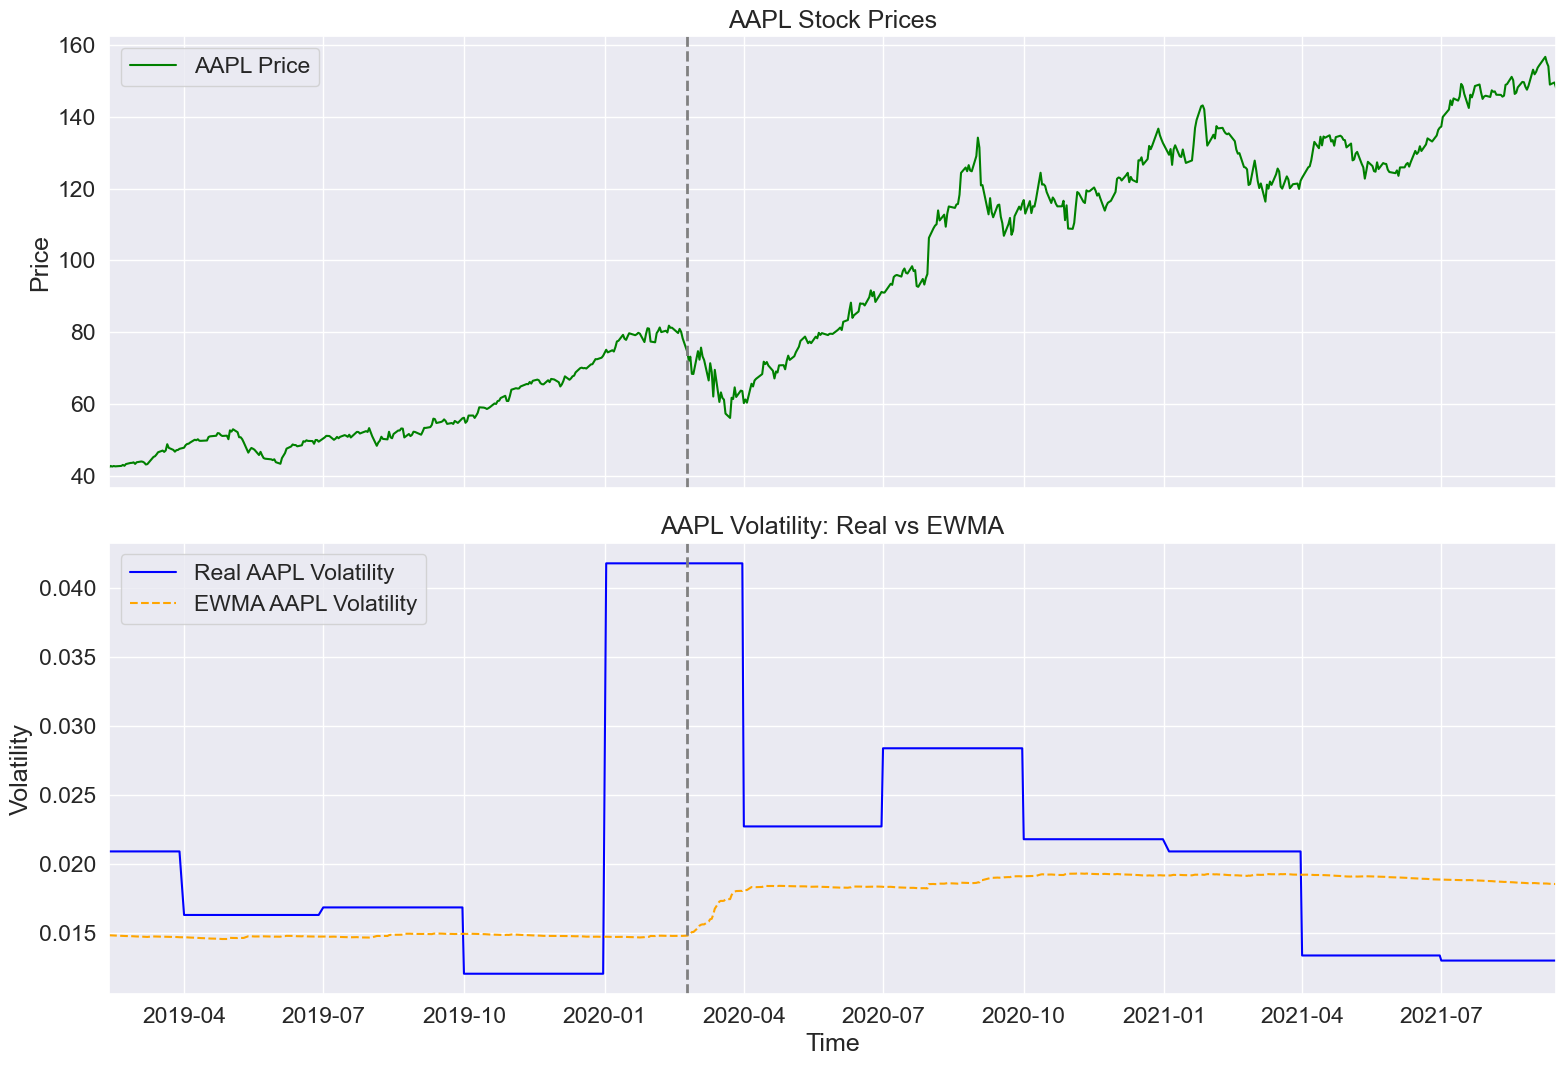

In [43]:
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE EWMA PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = validationDataWithPrices.index[0]
endDateFilter = validationDataWithPrices.index[-1]

plot_prices_volatilities_for_ewma(validationDataWithPrices, df_volatility_aapl['AAPL Volatility'], startDateFilter, endDateFilter, df_ewma_volatility_aapl['AAPL Volatility'], 'AAPL')

# Test Phase for EWMA predictor

In this test phase i will use the best value for beta found in the validation phase to see the performance of the model on the test set and i will plot some charts to compare the volatility predicted by the model with the ground truth.

ewma_halflife used: 13.513407333964874



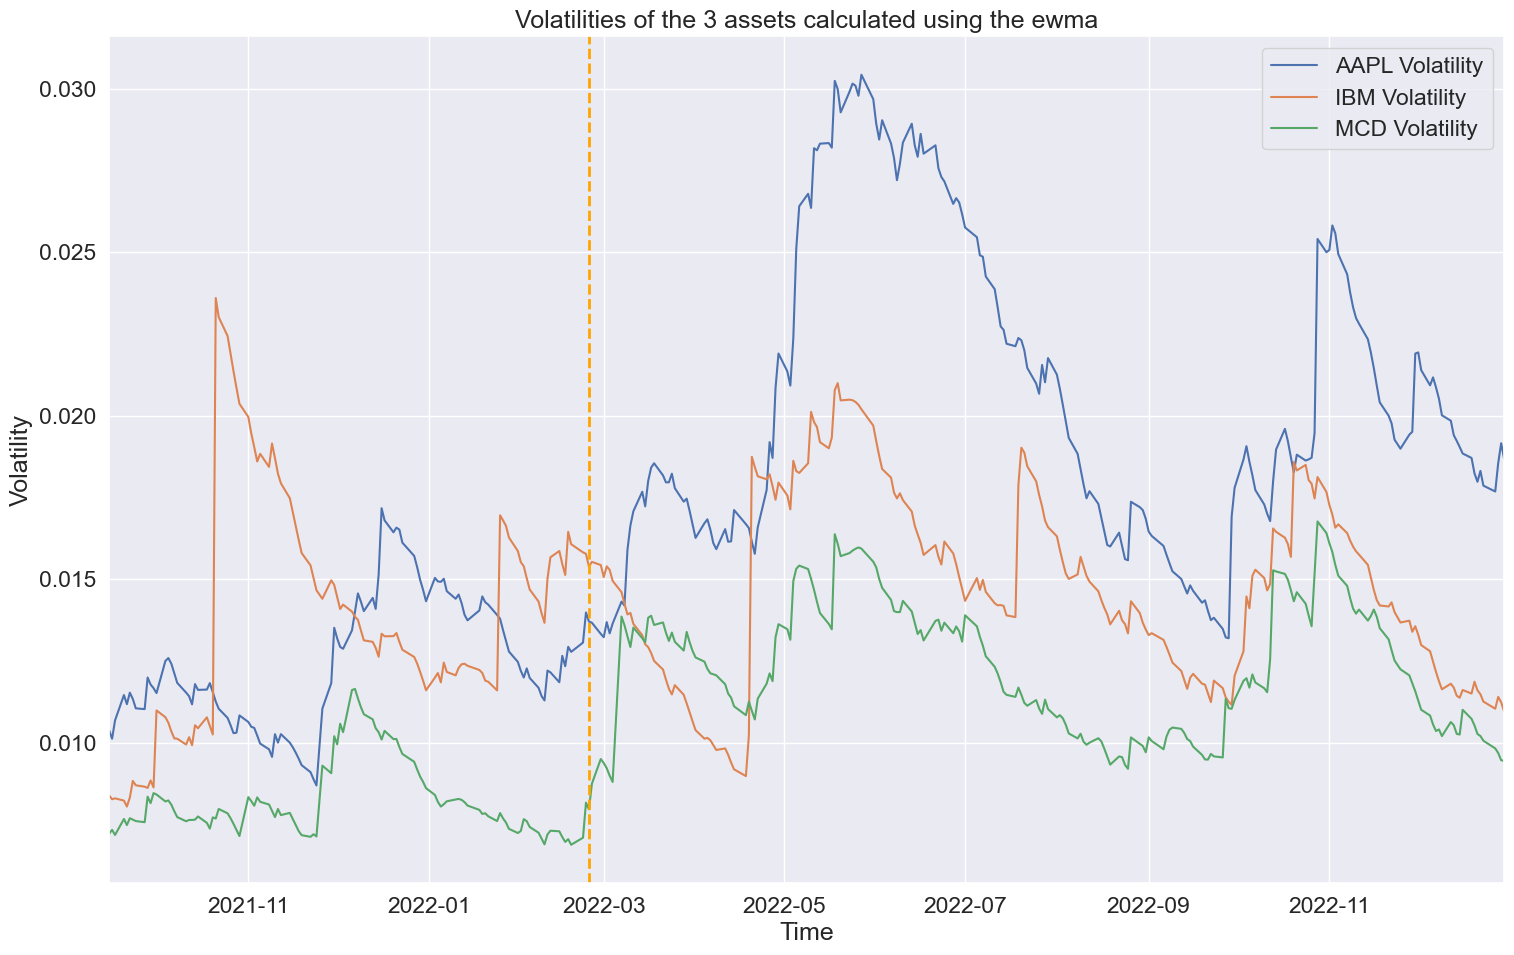

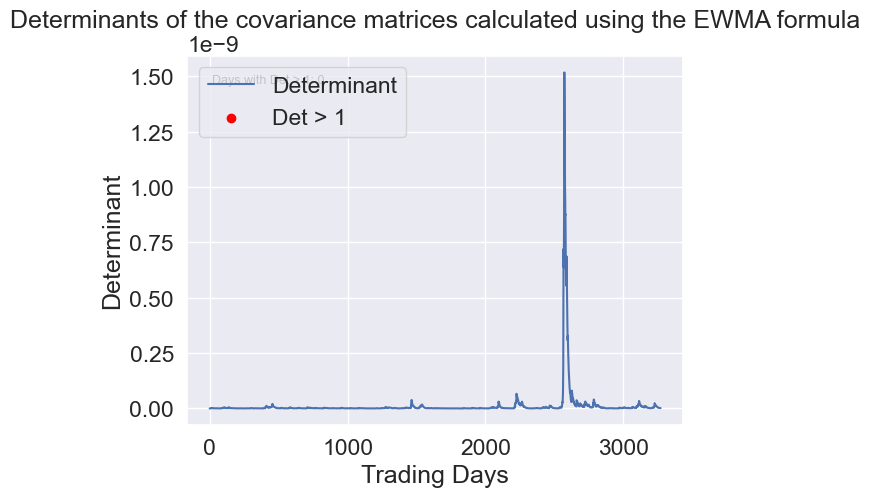

In [44]:
# prepare the date for the test phase
prescientAlreadyPrinted = False
startingTestDate = testDataWithPercentageChange.index[0].strftime("%Y-%m-%d")
endingTestDate = testDataWithPercentageChange.index[-1].strftime("%Y-%m-%d")

# select the best beta value for the EWMA predictor (the one found in the previous step)
beta = 0.95

ewma_halflife = -np.log(2) / np.log(beta)

# now i will use the best beta value to perform the test phase

# now i want to print the repective value of beta: the beta is the value of the decay factor used in the ewma formula
print("ewma_halflife used: " + str(ewma_halflife) + "\n")

# ewma is a dictionary that contains the covariance matrix calculated using the ewma formula written inside the paper
# the key of the dictionary is the timestamp and the value is the covariance matrix calculated for that day
ewmaDict = dict(_ewma_cov(stocksPercentageChangeReturn, ewma_halflife))

ewma_volatilities = {}

for date, cov_matrix in ewmaDict.items():
    volatilities = np.sqrt(np.diag(cov_matrix.values))
    ewma_volatilities[date] = pd.DataFrame(data = volatilities, index = cov_matrix.index, columns = ["volatility"])

# now ewma_volatilities is a dictionary that contains the real volatilities of the 3 assets for every day with the same key of the ewmaDict dictionary(the timestamp)

# now filter the ewma volatilities between the start and end date
real_volatility_startDate = pd.to_datetime(startingTestDate)
real_volatility_endDate = pd.to_datetime(endingTestDate)

# filter the dictionary
ewma_volatilities = {k: v for k, v in ewma_volatilities.items() if k >= real_volatility_startDate and k <= real_volatility_endDate}
    
# now separate the real volatilities of the 3 assets in 3 different dataframes
ewma_volatility_dict_aapl = {}
ewma_volatility_dict_ibm = {}
ewma_volatility_dict_mcd = {}

for date, volatilities in ewma_volatilities.items():
    ewma_volatility_dict_aapl[date] = volatilities.loc[7]["volatility"] # 7 is the PERMCO code of AAPL
    ewma_volatility_dict_ibm[date] = volatilities.loc[20990]["volatility"] # 20990 is the PERMCO code of IBM
    ewma_volatility_dict_mcd[date] = volatilities.loc[21177]["volatility"] # 21177 is the PERMCO code of MCD

# Convert the dictionaries to DataFrames for easier manipulation and plotting
df_ewma_volatility_aapl = pd.DataFrame(list(ewma_volatility_dict_aapl.items()), columns=['Date', 'AAPL Volatility'])
df_ewma_volatility_ibm = pd.DataFrame(list(ewma_volatility_dict_ibm.items()), columns=['Date', 'IBM Volatility'])
df_ewma_volatility_mcd = pd.DataFrame(list(ewma_volatility_dict_mcd.items()), columns=['Date', 'MCD Volatility'])

# Set the 'Date' column as the index
df_ewma_volatility_aapl.set_index('Date', inplace=True)
df_ewma_volatility_ibm.set_index('Date', inplace=True)
df_ewma_volatility_mcd.set_index('Date', inplace=True)

# Plot the real volatilities of the 3 assets
plt.figure(figsize=(18, 11))
plt.plot(df_ewma_volatility_aapl, label='AAPL Volatility')
plt.plot(df_ewma_volatility_ibm, label='IBM Volatility')
plt.plot(df_ewma_volatility_mcd, label='MCD Volatility')
plt.legend()
plt.title("Volatilities of the 3 assets calculated using the ewma")
plt.xlabel("Time")
plt.ylabel("Volatility")

# Adding vertical lines for specific events
plt.axvline(pd.Timestamp('2020-02-24'), color='gray', linestyle='--', lw=2)  # COVID start
plt.axvline(pd.Timestamp('2022-02-24'), color='orange', linestyle='--', lw=2)  # Ukraine War start

# set x-axis limits to match the start and end dates
plt.xlim(left=df_ewma_volatility_aapl.index[0], right=df_ewma_volatility_aapl.index[-1])
plt.show()

# here i study the determinants of the covariance matrices calculated using the ewma formula
determinants_ewma = []
indices = []  # To store the indices for the x-axis
days_greater_than_one_indices = []  # To store indices where determinant > 1
days_greater_than_one_values = []  # To store determinant values where > 1

for index, (date, cov_matrix) in enumerate(ewmaDict.items()):
    determinant = np.linalg.det(cov_matrix)
    determinants_ewma.append(determinant)
    indices.append(index)
    if determinant > 1:
        days_greater_than_one_indices.append(index)
        days_greater_than_one_values.append(determinant)

# Plotting all determinants
plt.plot(indices, determinants_ewma, label='Determinant', zorder=1)

# Highlighting determinants > 1 with red dots
plt.scatter(days_greater_than_one_indices, days_greater_than_one_values, color='red', zorder=2, label='Det > 1')

# Adding a text annotation for the count of days with determinant > 1
plt.text(0.05, 0.95, f'Days with Det > 1: {len(days_greater_than_one_indices)}', transform=plt.gca().transAxes, fontsize=9, verticalalignment='top')

plt.title("Determinants of the covariance matrices calculated using the EWMA formula")
plt.xlabel("Trading Days")
plt.ylabel("Determinant")
plt.legend()

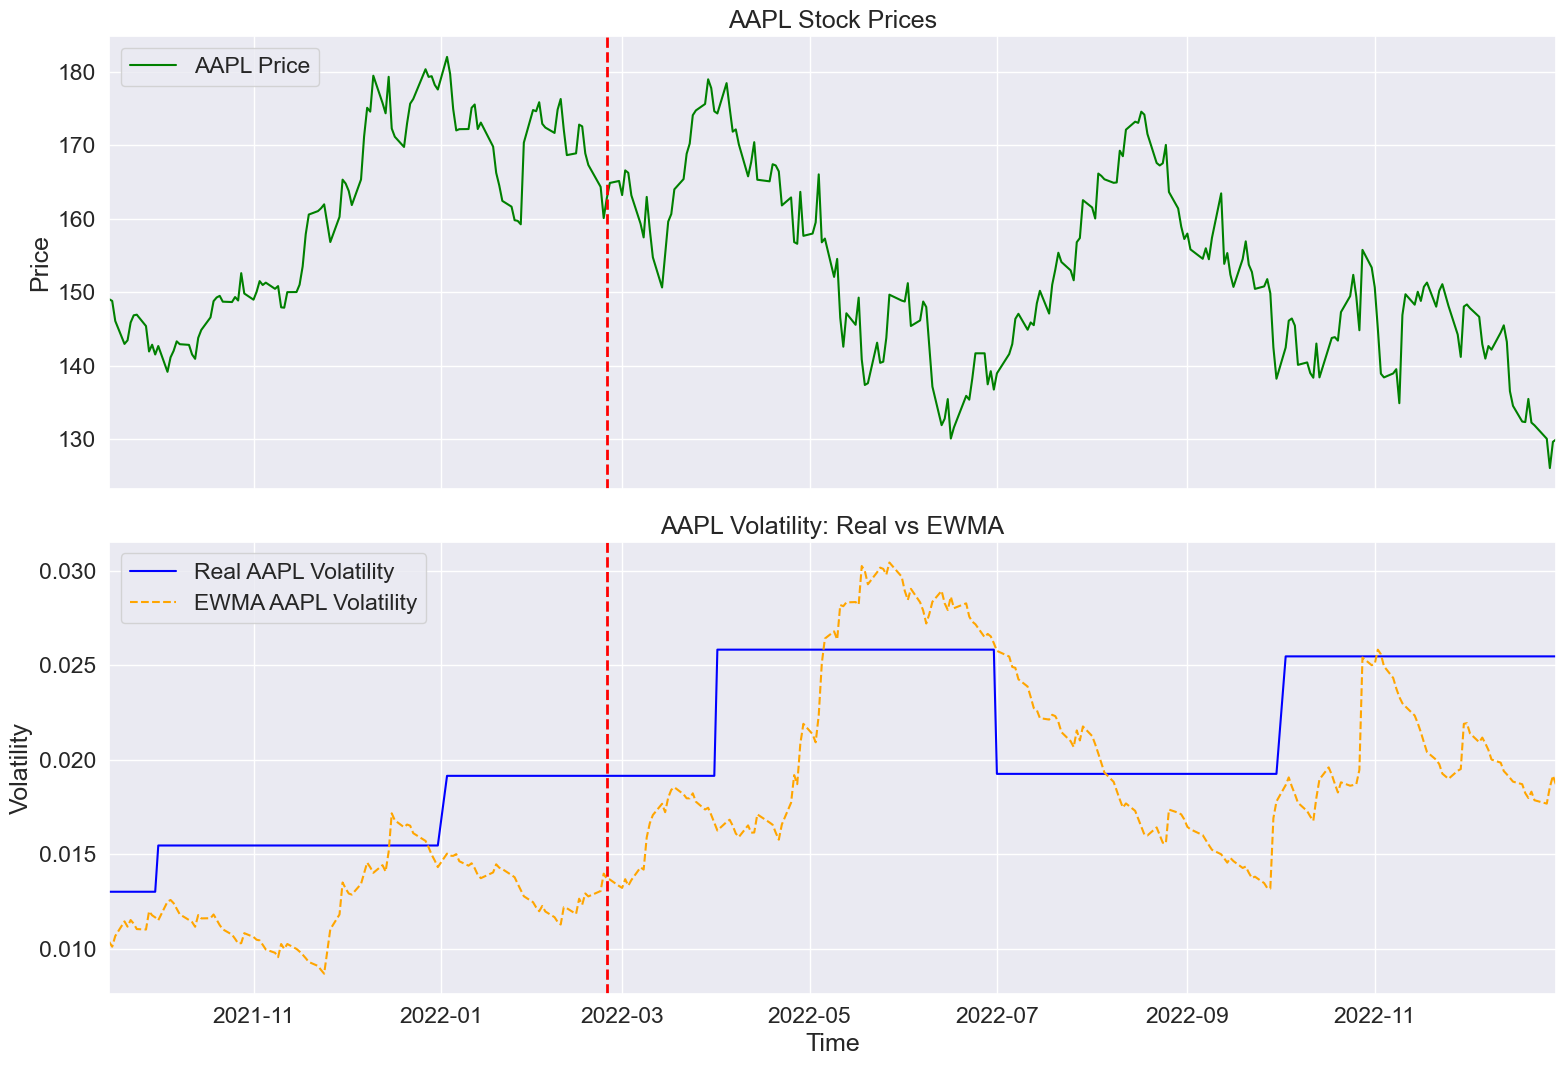

In [45]:
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE EWMA PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = testDataWithPrices.index[0]
endDateFilter = testDataWithPrices.index[-1]

plot_prices_volatilities_for_ewma(testDataWithPrices, df_volatility_aapl['AAPL Volatility'], startDateFilter, endDateFilter, df_ewma_volatility_aapl['AAPL Volatility'], 'AAPL')

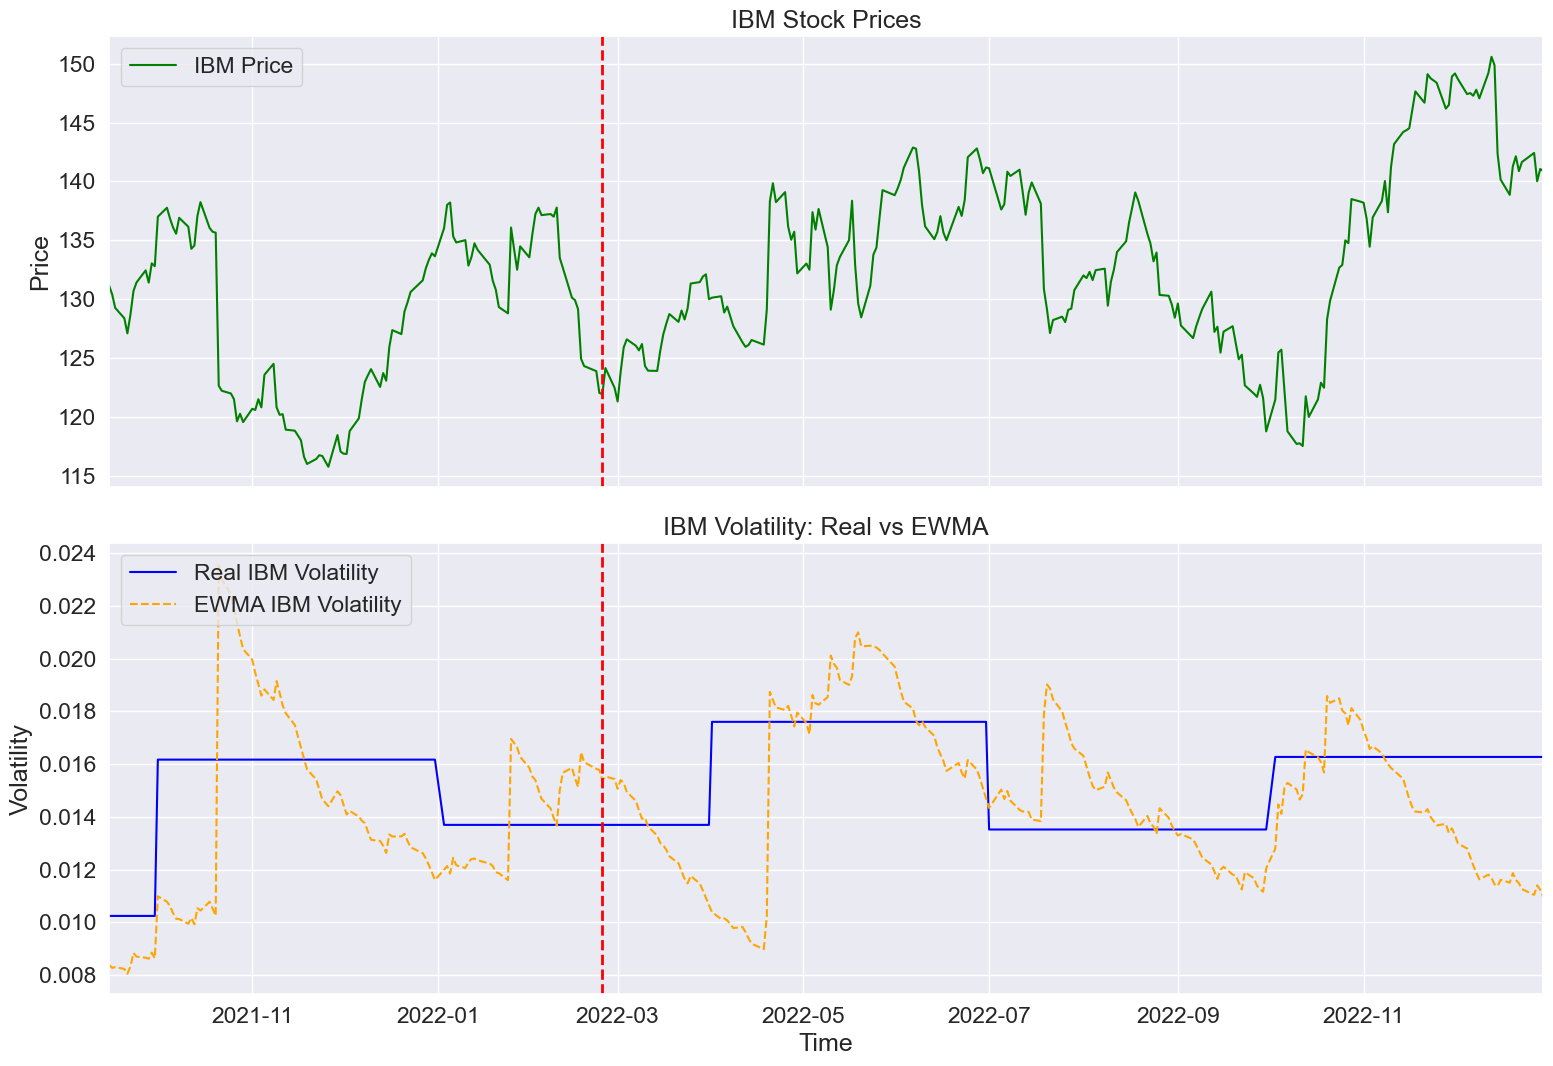

In [46]:
startDateFilter = testDataWithPrices.index[0]
endDateFilter = testDataWithPrices.index[-1]

plot_prices_volatilities_for_ewma(testDataWithPrices, df_volatility_ibm['IBM Volatility'], startDateFilter, endDateFilter, df_ewma_volatility_ibm['IBM Volatility'], 'IBM')

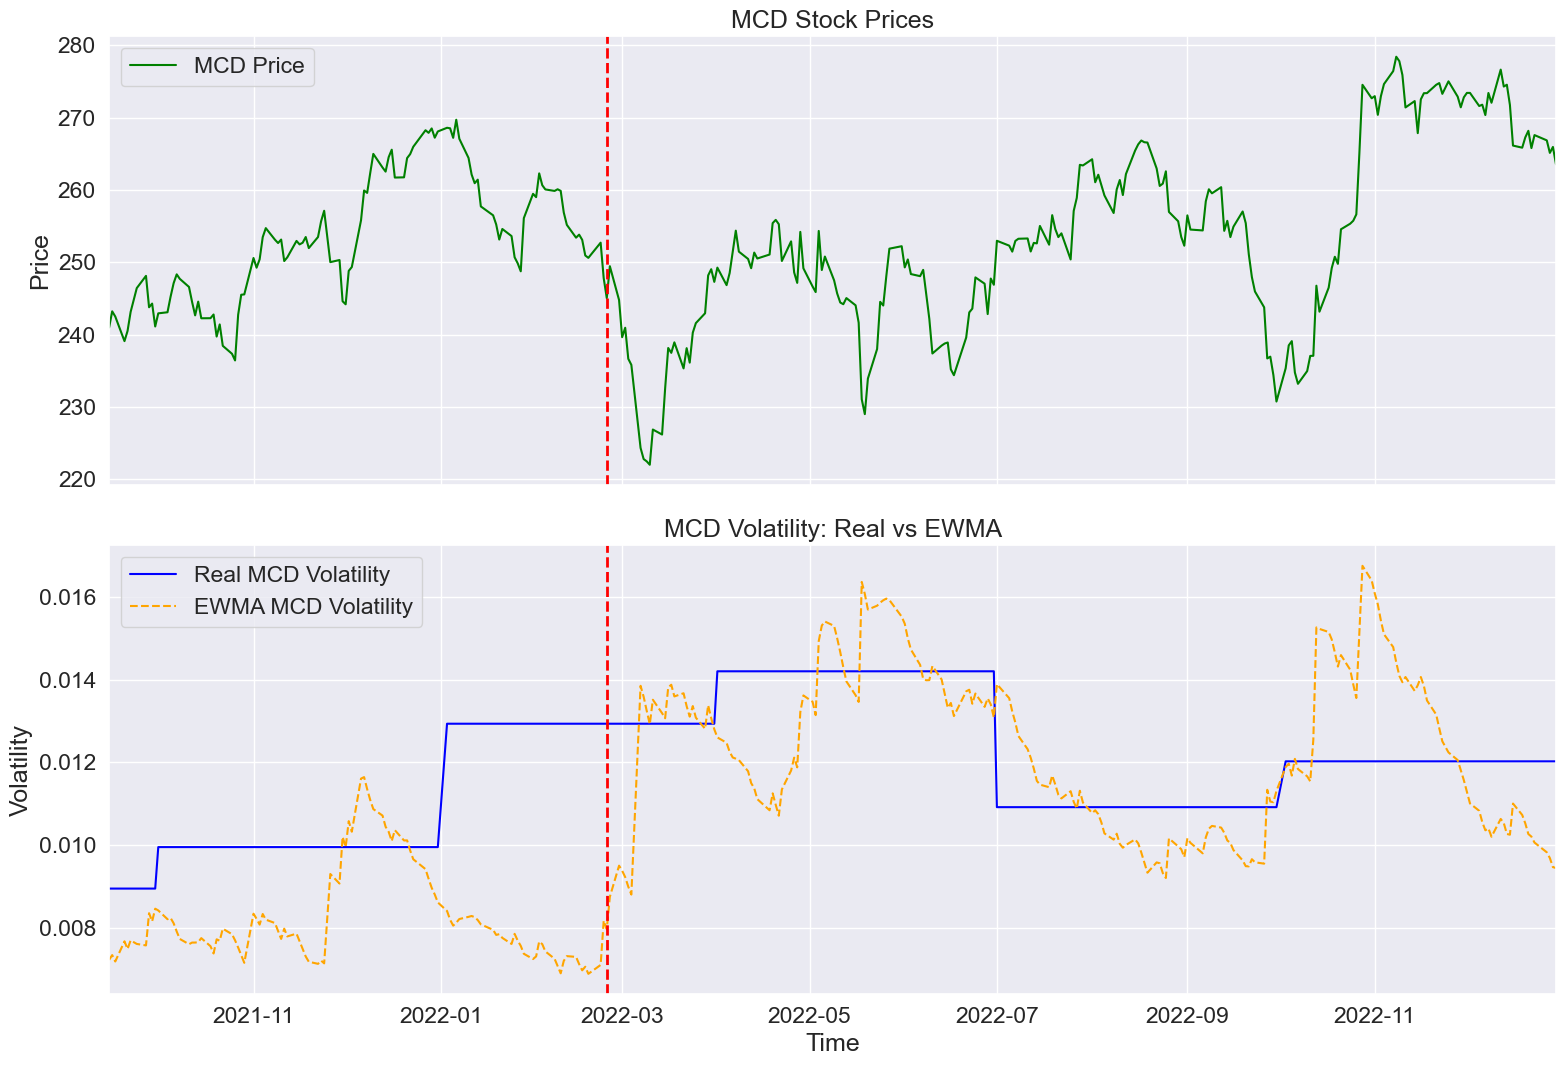

In [47]:
startDateFilter = testDataWithPrices.index[0]
endDateFilter = testDataWithPrices.index[-1]

plot_prices_volatilities_for_ewma(testDataWithPrices, df_volatility_mcd['MCD Volatility'], startDateFilter, endDateFilter, df_ewma_volatility_mcd['MCD Volatility'], 'MCD')

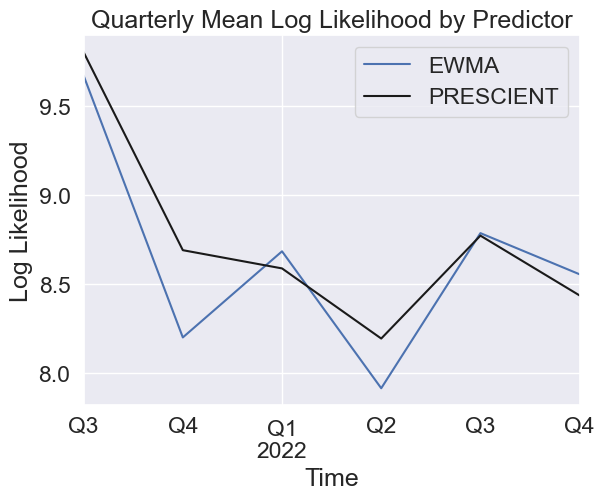



meanRegret: 0.100
stdRegret: 0.200
maxRegret: 0.500


meanLoglikelihoodEWMA: 8.600
stdLoglikelihoodEWMA: 0.500
maxLoglikelihoodEWMA: 9.700


meanLoglikelihoodPRESCIENT: 8.700
stdLoglikelihoodPRESCIENT: 0.500
maxLoglikelihoodPRESCIENT: 9.800

EWMA MSE
mean: 0.0000011671
std: 0.0000007858
max: 0.0000022791


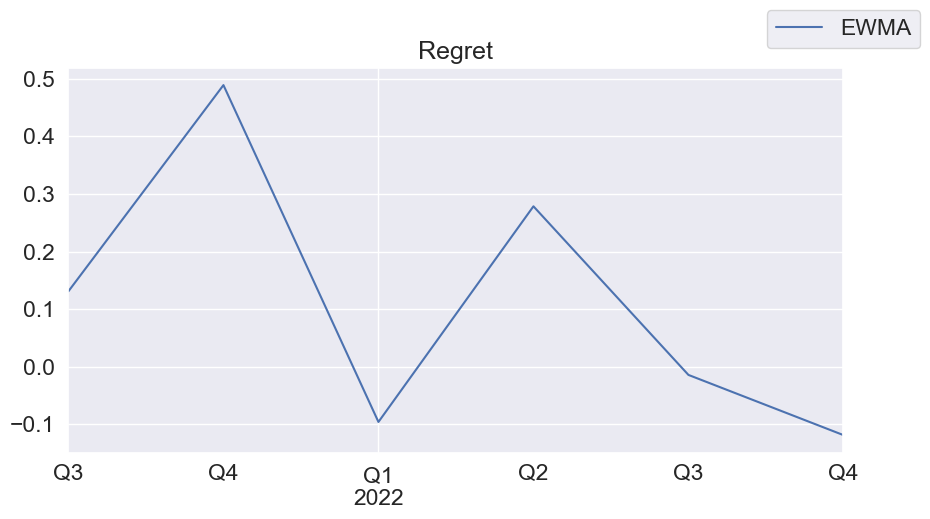

In [48]:
# NOW I DO THE LAST THING; THE COMPARISON BETWEEN THE EWMA PREDICTOR AND THE PRESCIENT PREDICTOR IN TERMS OF 
# LOGLIKELIHOOD, LOGLIKELIHOOD REGRET AND MSE

# first of all define the starting and ending date for the test phase: take the first and the last date of the test dataset

startingTestDate = testDataWithPercentageChange.index[0].strftime("%Y-%m-%d")
endingTestDate = testDataWithPercentageChange.index[-1].strftime("%Y-%m-%d")

start_date = pd.to_datetime(startingTestDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingTestDate, format="%Y-%m-%d")

names = ["EWMA", "PRESCIENT"]

#these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
predictors_temp = [ewmaDict, prescientDict]
predictors = [] # so this is a list of dictionaries

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})


#
# LOG-LIKELIHOODS
#

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
    }

    where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
'''

log_likelihoods = {}
for i, predictorDict in enumerate(predictors):

    # if the predictor is the prescient predictor, i have to use the uniformly distributed dataset
    if names[i] == "PRESCIENT":
        returns_temp = uniformlyDistributedReturns.loc[pd.Series(predictorDict).index].values[1:]
    
    else:
        returns_temp = stocksPercentageChangeReturn.loc[pd.Series(predictorDict).index].values[1:]

    times = pd.Series(predictorDict).index[1:]
    Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)


# Iterate through each predictor in the log_likelihoods dictionary
for name in log_likelihoods.keys():
    if name == 'PRESCIENT':
        # Resample by quarter, take the mean, and plot with specific color and label
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        # Resample by quarter, take the mean, and plot with default settings
        log_likelihoods[name].resample("Q").mean().plot(label=name)


plt.xlabel('Time')  # Set the x-axis label
plt.ylabel('Log Likelihood')  # Set the y-axis label
plt.title('Quarterly Mean Log Likelihood by Predictor')  # Set the title of the plot
plt.legend()  # Show the legend to identify each predictor
plt.show()  # Display the plot

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(...),
        EWMA: pd.Series(...),
        MGARCH: pd.Series(...),
        PRESCIENT: pd.Series(...),
    }

    where each pd.series is a series of regret for each timestamp: so there is the 
    regret value (the difference between the log-likelihood of the prescient model and the log-likelihood of the model) for each timestamp
'''
regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(1, 1.1), loc='center', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);
plt.title("Regret")

for name in regrets:
    if name != "PRESCIENT":

        #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
        regret = regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
        # so the regret variable is a series of average regret for each quarter
        
        regretMetrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
        # the round(1) function to each of these metrics, which rounds the result to one decimal place,

        # save the regret mean values to plot a chart
        ewmaMeanRegretValues.append(regretMetrics[0])

print("\n")
print(f"meanRegret: {regretMetrics[0]:.3f}")
print(f"stdRegret: {regretMetrics[1]:.3f}")
print(f"maxRegret: {regretMetrics[2]:.3f}")

# copy the log-likelihoods dictionary
log_likelihoods_copy = log_likelihoods.copy()

# do the same thing for log-likelihoods dictionary
for name in log_likelihoods_copy:
    logLikelihood = log_likelihoods_copy[name].resample("Q").mean()
    logLikelihoodMetrics = (np.mean(logLikelihood).round(1), np.std(logLikelihood).round(1), np.max(logLikelihood).round(1))

    print("\n")
    print(f"meanLoglikelihood{name}: {logLikelihoodMetrics[0]:.3f}")
    print(f"stdLoglikelihood{name}: {logLikelihoodMetrics[1]:.3f}")
    print(f"maxLoglikelihood{name}: {logLikelihoodMetrics[2]:.3f}")


#
# MSEs
#

for i, predictorDict in enumerate(predictors):
    if names[i] != "PRESCIENT":
        MSE_temp = MSE(stocksPercentageChangeReturn, predictorDict).resample("Q").mean()

        print("\n" + names[i] + " MSE")
        print(f"mean: {MSE_temp.mean():.10f}")
        print(f"std: {MSE_temp.std():.10f}")
        print(f"max: {MSE_temp.max():.10f}")
